In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
FREQS = [240, 120, 60, 30, 15, 5, 3, 1]
base = 'USDT'
days = 2

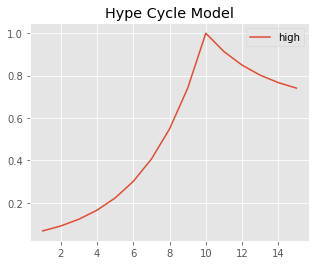

In [4]:
from hypecommons import download_history_fast, plot, to_interval
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# from math import exp
# print(list(reversed([round(2/3 + exp(3/10*x)/exp(3) / 3, 4) for x in range(11)])))

model_high = [0.0672, 0.0907, 0.1225, 0.1653, 0.2231,
              0.3012, 0.4066, 0.5488, 0.7408, 1.0,
              0.9136, 0.8496, 0.8022, 0.7671, 0.741]

def plot_seq(seq, title, label, show=True):
    plt.rcParams["figure.figsize"] = (5, 4)
    plt.plot(range(1, 1+len(seq)), seq, label=label)
    plt.title(title)
    plt.legend(loc='best')
    if show:
        plt.show()

plot_seq(model_high, "Hype Cycle Model", 'high')

## Coinwise Analysis

In [5]:
def download(coin, base, freqs=FREQS, start=None, silent=False):
    if start is None:
        start = (datetime.now() - timedelta(days=days)).strftime('%Y%m%d%H%M%S')

    dfs = {}
    for freq in freqs:
        dfs[freq] = download_history_fast(f"{coin}{base}", start, freq=freq, days=days, silent=silent,
                                         folder='hypecycle')
    
    if start is None:
        print(start)
    return dfs

In [6]:
def diff_and_plot(coin, base, dfs, silent=False):
    for freq in freqs:
        dfs[freq]['close_diff'] = dfs[freq]['close'].diff().rolling(window=3).mean()
    
    if not silent:
        freq_plot = 15
        plot(plt.plot, dfs[freq_plot], ['close', 'high', 'low'], fig_size=(16, 6), title=f"{coin}-{base}")
        plot(plt.bar, dfs[freq_plot], ['close_diff'], fig_size=(16, 6), bar_size=freq/200)

In [7]:
def pivot_by_frequency(coin, base, dfs, silent=False):
    if not silent:
        plt.rcParams["figure.figsize"] = (16, 12)
        fig, axs = plt.subplots(3, 3, sharex=False)

    df_sels = {}

    for i, freq in zip(range(len(freqs)), reversed(freqs)):
        peak = dfs[freq]['close_diff'].argmax()
        start_range = max(0, peak-9)
        end_range = min(len(dfs[freq]), peak+6)
        df_sel = dfs[freq].iloc[start_range:end_range]
        df_sels[freq] = df_sel
        if not silent:
            pos = i // 3, i % 3
            axs[pos].plot(df_sel.index, df_sel['close'], label='close')
            axs[pos].plot(df_sel.index, df_sel['high'], label='high')
            axs[pos].plot(df_sel.index, df_sel['low'], label='low')
            axs[pos].set_title(f"{coin}-{base} peak at freq={freq}")
            axs[pos].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    if not silent:
        fig.tight_layout()
        plt.show()
    
    return df_sels

In [8]:
from math import sqrt
from sklearn.metrics import mean_squared_error

def rmse(x, y):
    return sqrt(mean_squared_error(x, y))

def find_best_fit(df_sels, partial_patterns=False, silent=False):
    scores = {}
    for freq, df_sel in df_sels.items():
        df_sel = df_sel.copy()
        
        x_min = df_sel['high'].min()
        x_max = df_sel['high'].max()
        for col in ['close', 'low', 'high']:
            df_sel[col] = (df_sel[col] - x_min) / (x_max - x_min)
            
        score = rmse(df_sel['high'], model_high[:len(df_sel)])
        if not partial_patterns and len(model_high) > len(df_sel):
            # penalise shorter sequences
            score = score * (1+(len(model_high)-len(df_sel) / len(model_high)))
        scores[freq] = {'score': score, 'data': df_sel}
        
    sorted_scores = sorted(scores.items(), key=lambda item: item[1]['score'])
    freq, results = sorted_scores[0]
    results['freq'] = freq
    if not silent:
        print({res[0]: res[1]['score'] for res in sorted_scores})
    return results

In [9]:
from tqdm import tqdm
import math
import sys, traceback

def process(coin, base, start=None, silent=False):
    dfs = download(coin, base, start=start, silent=silent)
    diff_and_plot(coin, base, dfs, silent=silent)
    df_sels = pivot_by_frequency(coin, base, dfs, silent=silent)
    return find_best_fit(df_sels, partial_patterns=False, silent=silent) 

def coinwise_analysis(coins, base, start=None, silent=True):
    results = {}
    iterator = tqdm(coins, desc='Processing coins...', ncols=100) if silent else coins
    for coin in iterator:
        try:
            results[coin] = process(coin, base, start=start, silent=silent)
        except Exception as e:
            print(f"{coin} -> {e}")
            results[coin] = None
            traceback.print_exc(file=sys.stdout)
    if not silent:
        print("-"*110)
    
    num_rows = math.ceil(len(coins) / 3)

    plt.rcParams["figure.figsize"] = (16, 4 * num_rows)
    fig, axs = plt.subplots(num_rows, 3, sharex=False)

    for i, (coin, result) in enumerate(results.items()):
        if result is None:
            continue
        df_plot = result['data']
        freq = result['freq']
        
        if num_rows == 1:
            pos = i
        else:
            pos = i // 3, i % 3
        axs[pos].plot(df_plot.index, df_plot['close'], label='close')
        axs[pos].plot(df_plot.index, df_plot['high'], label='high')
        axs[pos].plot(df_plot.index, df_plot['low'], label='low')
        axs[pos].set_title(f"{coin}-{base} peak at freq={freq}")
        axs[pos].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    fig.tight_layout()
    plt.show()
    
    return results

In [10]:
# results = coinwise_analysis(['ROSE'], 'BUSD', start='20211118181016', silent=False)

In [11]:
# results = coinwise_analysis(['COCOS', 'MITH', 'GALA', 'POWR'], 'USDT', silent=True)

In [12]:
def get_change(coin, base):
    start = (datetime.now() - timedelta(days=days)).strftime('%Y%m%d%H%M%S')
    df = download_history_fast(f"{coin}{base}", start, freq=60, days=days, silent=True)
    return (df['close'].iloc[-1] - df['close'].iloc[0]) / df['close'].iloc[0]

In [13]:
import binance_bot

bot = binance_bot.BinanceBot('BTC', 'USDT') # any two will do

def get_binance_coins(base='USDT'):
    coins = []
    info = bot.get_exchange_info()
    for symbol in info['symbols']:
        s = symbol['symbol']
        if s.endswith(base):
            coins.append(s[:-len(base)])
    return coins

def retrieve_changes(all_coins, base):
    changes = {}
    errors = []
    for coin in tqdm(all_coins, desc='Retrieving changes...', ncols=100):
        try:
            changes[coin] = get_change(coin, base)
        except IndexError:
            errors.append(coin)
#     print(f"errors: {errors}")
    return changes

In [14]:
def compute_hype_cycle_index(df_ahc, seq, show=True):
    df_i = df_ahc[:len(seq)].copy()
    df_i_max = df_i['mid'].max()
    df_i['seq'] = [(seq_i - seq.min()) / (seq.max() - seq.min()) * df_i_max for seq_i in seq]
    if show:
        df_i.plot()
        plt.show()
    return rmse(df_i['mid'], df_i['seq']) 

# compute_hype_cycle_index(df_ahc, np.random.rand(15))

## Building the Average Hype Cycle

Processing coins...: 100%|██████████████████████████████████████████| 42/42 [03:35<00:00,  5.13s/it]


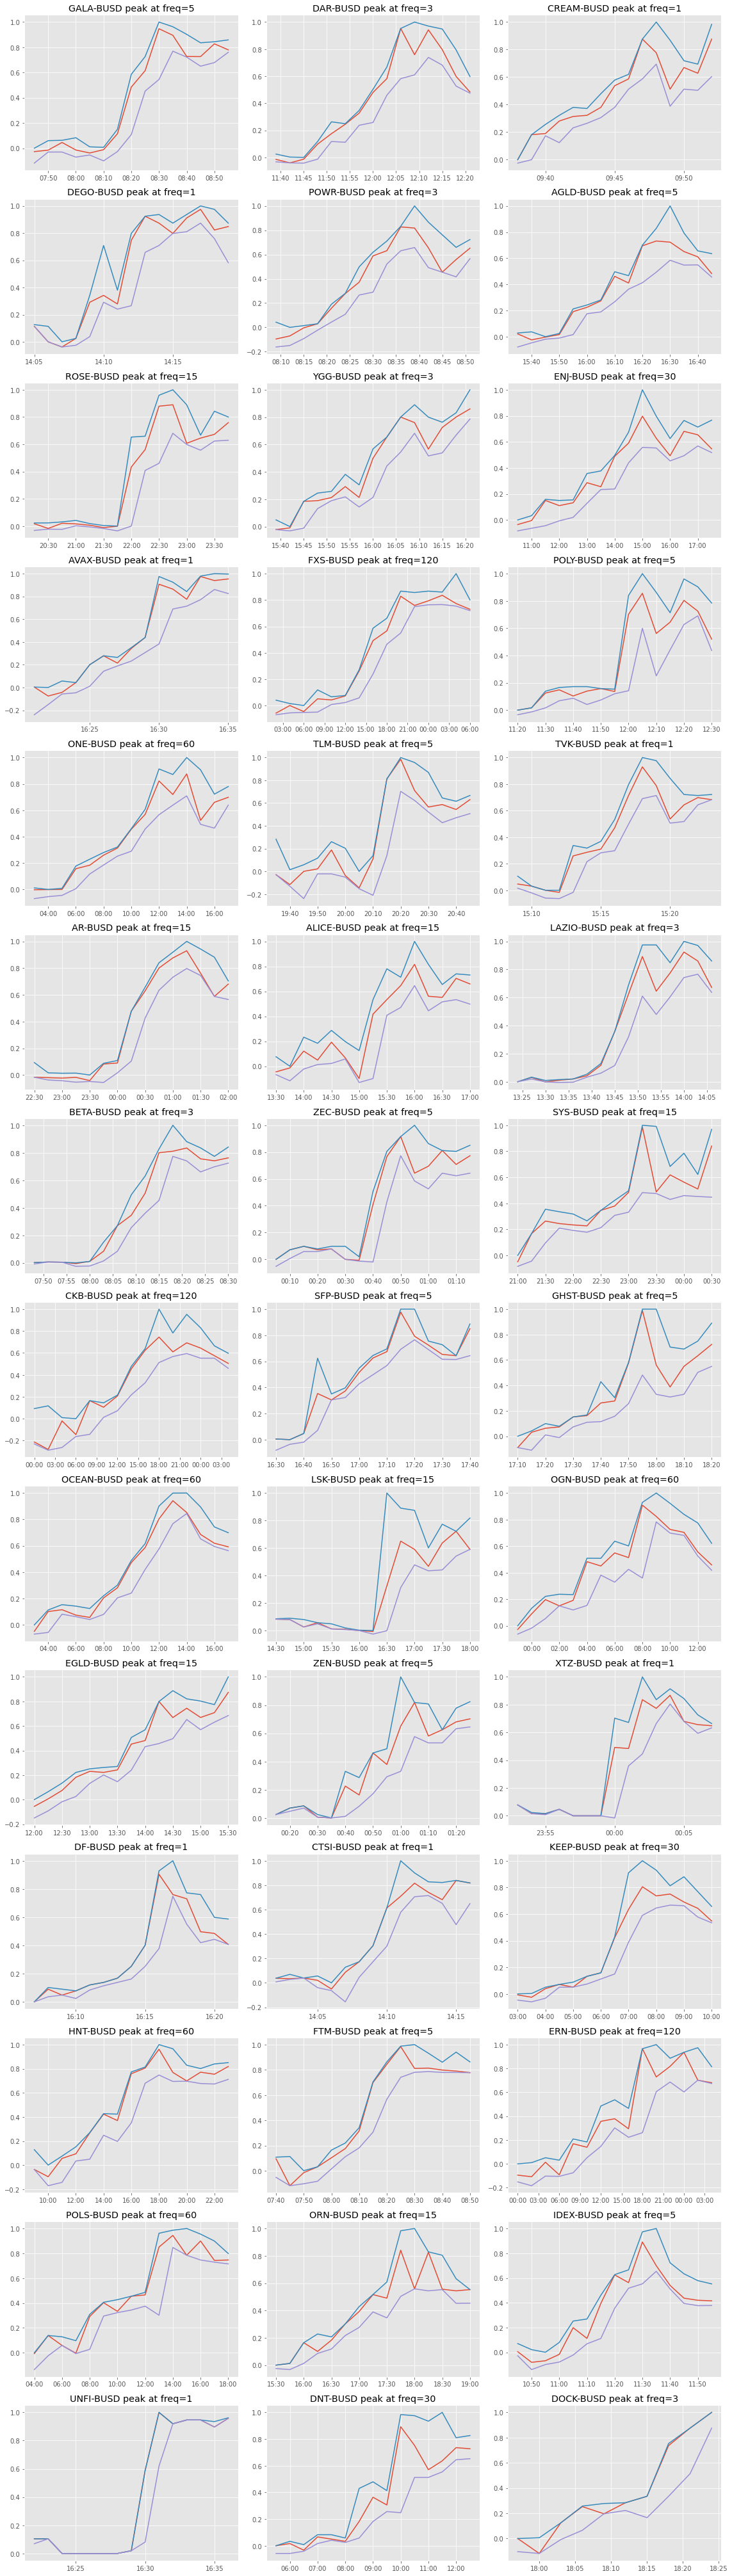

In [107]:
base = 'BUSD'
all_coins = get_binance_coins(base=base)

N = 42
top_performing_coins = [item[0] for item in sorted(changes.items(), key=lambda x: x[1], reverse=True)[:N]]

results = coinwise_analysis(top_performing_coins, base, silent=True)

In [114]:
print(top_performing_coins)

['GALA', 'DAR', 'CREAM', 'DEGO', 'POWR', 'AGLD', 'ROSE', 'YGG', 'ENJ', 'AVAX', 'FXS', 'POLY', 'ONE', 'TLM', 'TVK', 'AR', 'ALICE', 'LAZIO', 'BETA', 'ZEC', 'SYS', 'CKB', 'SFP', 'GHST', 'OCEAN', 'LSK', 'OGN', 'EGLD', 'ZEN', 'XTZ', 'DF', 'CTSI', 'KEEP', 'HNT', 'FTM', 'ERN', 'POLS', 'ORN', 'IDEX', 'UNFI', 'DNT', 'DOCK']


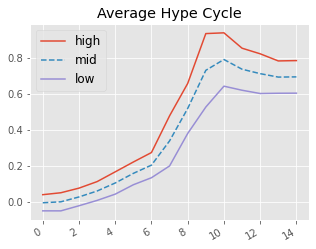

In [142]:
import pandas as pd

def compute_average_hype_cycle(results):
    avg_hype_cycle = {}
    for col in ['high', 'low']:
        
        hype_cycles = [list(result['data'][col]) for coin, result in results.items()]
        for i in range(len(hype_cycles)):
            if len(hype_cycles[i]) < 15:
                del hype_cycles[i]
                
        avg_hype_cycle[col] = np.mean(hype_cycles, axis=0)
    plt.show()
    df_ahc = pd.DataFrame([{'high': high, 'low': low} for high, low in zip(avg_hype_cycle['high'], avg_hype_cycle['low'])])
    df_ahc['mid'] = (df_ahc['high'] + df_ahc['low']) / 2
    plot(plt.plot, df_ahc, ['high', 'mid', 'low'], fig_size=(5, 4), is_date=False, title="Average Hype Cycle",
        linestyles=['-', '--', '-'])
    return df_ahc
    
df_ahc = compute_average_hype_cycle(results)

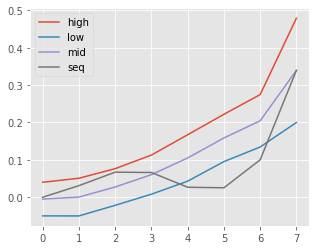

0.06834703874234253

In [226]:
df = download_history_fast(f"GALABUSD", '20211120074500', days=1, freq=5)
compute_hype_cycle_index(df_ahc, ((df['open']+df['close'])/2)[:8])

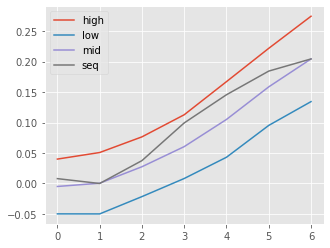

0.024186217783157295

In [254]:
df = download_history_fast(f"DARBUSD", '20211120113900', days=1, freq=3)
compute_hype_cycle_index(df_ahc, ((df['open']+df['close'])/2)[:7])

In [ ]:
base = 'USDT'
all_coins = get_binance_coins(base=base)
changes = retrieve_changes(all_coins, base)
top_50_coins = [item[0] for item in sorted(changes.items(), key=lambda x: x[1], reverse=True)[:50]]

In [248]:
import pickle

hc_data = {
    'df_ahc': df_ahc,
    'all_coins': all_coins,
    'changes': changes,
    'top_50_coins': top_50_coins,
}

with open('hc-data.pkl', 'wb') as f_out:
    pickle.dump(hc_data, f_out)

## Running search

In [15]:
import os
import glob

def delete_cache():
    files = glob.glob('hypecycle/*.json')
    for f in files:
        os.remove(f)

In [16]:
import pickle

with open('hc-data.pkl', 'rb') as f:
    hc_data = pickle.load(f)
    
df_ahc = hc_data['df_ahc']
# all_coins = hc_data['all_coins']
# changes = hc_data['changes']
# top_50_coins = hc_data['top_50_coins']

In [17]:
def run_search(base, all_coins, freqs=FREQS, backtest=False, datapoints=8, thr=0.04, blacklisted=[]):
    search = {}
    errors = []
    
    all_coins_ = list(all_coins)
    for bl in blacklisted:
        all_coins_.remove(bl)
    
    for coin in all_coins_:
        if backtest:
            start = (datetime.now() - timedelta(days=31)).strftime('%Y%m%d%H%M%S')
        else:
            start = None # real-time search
        try:
            dfs = download(coin, base, freqs=freqs, start=start, silent=True)
        except:
            # some coins throw errors
            continue
        search[coin] = {}
        for freq in freqs:
            seq = dfs[freq]['close'].iloc[-datapoints:]
            try:
                score = compute_hype_cycle_index(df_ahc, np.array(seq), show=False)
            except:
                errors.append((coin, freq))
                continue
            search[coin][freq] = {'seq': seq, 'score': score}
            if score <= thr:
                # visualise
                print((coin, base, freq, score))
                compute_hype_cycle_index(df_ahc, np.array(seq), show=True)
                delete_cache()
                return {'coin': coin, 'base': base, 'freq': freq, 'seq': seq, 'score': score}
    print(f"Errors: {errors}")
    delete_cache()
    return None

## Simulation

New search started on freq=[1, 3, 5, 15]...

('BTCDOWN', 'USDT', 1, 0.02924016347539743)


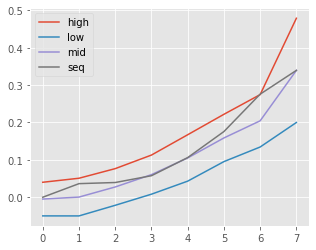

Buy at 0.00866 (2021-11-21 23:56:02.146242)
Waiting until 2021-11-21 23:58:20 local time...


{'iter': 0, 'buy_at': 0.00866, 'sell_at_10th': 0.008649, 'gain_at_10th': -0.0012702078521938636, 'sell_time_at_10th': Timestamp('2021-11-21 23:57:00'), 'sell_at_11th': 0.008635, 'gain_at_11th': -0.0028868360277135084, 'sell_time_at_11th': Timestamp('2021-11-21 23:58:00'), 'buy_time': Timestamp('2021-11-21 23:55:00'), 'buy_time_exact': Timestamp('2021-11-21 23:56:02.146242'), 'unblock_time': Timestamp('2021-11-21 23:58:20')}

New search started on freq=[1, 3, 5, 15]...

('FET', 'USDT', 5, 0.024034206195320124)


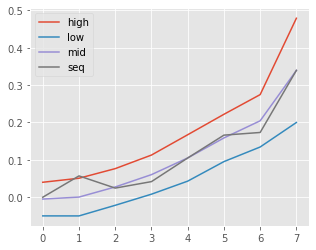

Buy at 0.906 (2021-11-21 23:59:48.992381)
Waiting until 2021-11-22 00:10:20 local time...


{'iter': 1, 'buy_at': 0.906, 'sell_at_10th': 0.9144, 'gain_at_10th': 0.009271523178807906, 'sell_time_at_10th': Timestamp('2021-11-22 00:05:00'), 'sell_at_11th': 0.8653, 'gain_at_11th': -0.04492273730684334, 'sell_time_at_11th': Timestamp('2021-11-22 00:10:00'), 'buy_time': Timestamp('2021-11-21 23:55:00'), 'buy_time_exact': Timestamp('2021-11-21 23:59:48.992381'), 'unblock_time': Timestamp('2021-11-22 00:10:20')}

New search started on freq=[1, 3, 5, 15]...

('AR', 'USDT', 1, 0.01873540179042718)


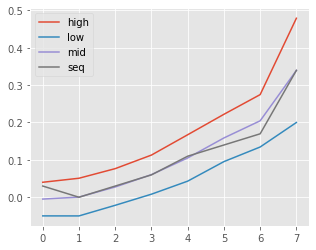

Buy at 64.2 (2021-11-22 00:24:58.861751)
Waiting until 2021-11-22 00:27:20 local time...


{'iter': 2, 'buy_at': 64.2, 'sell_at_10th': 64.11, 'gain_at_10th': -0.0014018691588785577, 'sell_time_at_10th': Timestamp('2021-11-22 00:26:00'), 'sell_at_11th': 64.09, 'gain_at_11th': -0.0017133956386292746, 'sell_time_at_11th': Timestamp('2021-11-22 00:27:00'), 'buy_time': Timestamp('2021-11-22 00:24:00'), 'buy_time_exact': Timestamp('2021-11-22 00:24:58.861751'), 'unblock_time': Timestamp('2021-11-22 00:27:20')}

New search started on freq=[1, 3, 5, 15]...

('KP3R', 'USDT', 5, 0.029390964068422957)


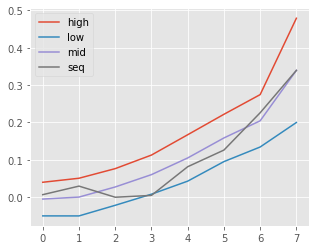

Buy at 1326.9 (2021-11-22 00:43:38.106688)
Waiting until 2021-11-22 00:55:20 local time...


{'iter': 3, 'buy_at': 1326.9, 'sell_at_10th': 1353.97, 'gain_at_10th': 0.020400934509005906, 'sell_time_at_10th': Timestamp('2021-11-22 00:50:00'), 'sell_at_11th': 1336.45, 'gain_at_11th': 0.007197226618433909, 'sell_time_at_11th': Timestamp('2021-11-22 00:55:00'), 'buy_time': Timestamp('2021-11-22 00:40:00'), 'buy_time_exact': Timestamp('2021-11-22 00:43:38.106688'), 'unblock_time': Timestamp('2021-11-22 00:55:20')}

New search started on freq=[1, 3, 5, 15]...

('IOTX', 'USDT', 1, 0.021480732361404863)


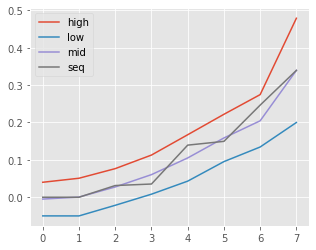

Buy at 0.22271 (2021-11-22 00:59:17.215326)
Waiting until 2021-11-22 01:02:20 local time...


{'iter': 4, 'buy_at': 0.22271, 'sell_at_10th': 0.22138, 'gain_at_10th': -0.0059718916977234875, 'sell_time_at_10th': Timestamp('2021-11-22 01:01:00'), 'sell_at_11th': 0.22144, 'gain_at_11th': -0.005702483049705866, 'sell_time_at_11th': Timestamp('2021-11-22 01:02:00'), 'buy_time': Timestamp('2021-11-22 00:59:00'), 'buy_time_exact': Timestamp('2021-11-22 00:59:17.215326'), 'unblock_time': Timestamp('2021-11-22 01:02:20')}

New search started on freq=[1, 3, 5, 15]...

('XRP', 'USDT', 5, 0.02704029479926651)


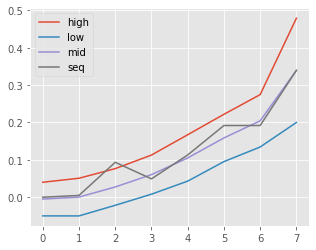

Buy at 1.0496 (2021-11-22 01:02:50.717586)
Waiting until 2021-11-22 01:15:20 local time...


{'iter': 5, 'buy_at': 1.0496, 'sell_at_10th': 1.0473, 'gain_at_10th': -0.0021913109756099376, 'sell_time_at_10th': Timestamp('2021-11-22 01:10:00'), 'sell_at_11th': 1.0458, 'gain_at_11th': -0.0036204268292683167, 'sell_time_at_11th': Timestamp('2021-11-22 01:15:00'), 'buy_time': Timestamp('2021-11-22 01:00:00'), 'buy_time_exact': Timestamp('2021-11-22 01:02:50.717586'), 'unblock_time': Timestamp('2021-11-22 01:15:20')}

New search started on freq=[1, 3, 5, 15]...

('GBP', 'USDT', 5, 0.027739101718666136)


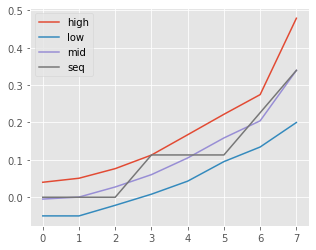

Buy at 1.34 (2021-11-22 01:22:25.220652)
Waiting until 2021-11-22 01:35:20 local time...


{'iter': 6, 'buy_at': 1.34, 'sell_at_10th': 1.339, 'gain_at_10th': -0.0007462686567165014, 'sell_time_at_10th': Timestamp('2021-11-22 01:30:00'), 'sell_at_11th': 1.339, 'gain_at_11th': -0.0007462686567165014, 'sell_time_at_11th': Timestamp('2021-11-22 01:35:00'), 'buy_time': Timestamp('2021-11-22 01:20:00'), 'buy_time_exact': Timestamp('2021-11-22 01:22:25.220652'), 'unblock_time': Timestamp('2021-11-22 01:35:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('TRXDOWN', 1), ('BCHUP', 1), ('BCHDOWN', 1), ('STRAX', 1), ('XLMDOWN', 1), ('OG', 1), ('RIF', 1), ('GNO', 1), ('GNO', 3), ('GNO', 5), ('USDP', 1)]
New search started on freq=[1, 3, 5, 15]...

('DAR', 'USDT', 1, 0.029724967099227034)


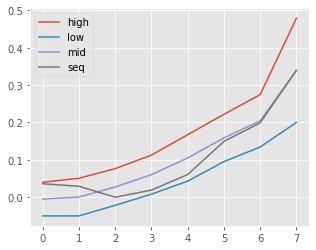

Buy at 3.05645 (2021-11-22 02:09:01.657039)
Waiting until 2021-11-22 02:11:20 local time...


{'iter': 7, 'buy_at': 3.05645, 'sell_at_10th': 3.06481, 'gain_at_10th': 0.002735199332559062, 'sell_time_at_10th': Timestamp('2021-11-22 02:10:00'), 'sell_at_11th': 3.06331, 'gain_at_11th': 0.0022444339020759665, 'sell_time_at_11th': Timestamp('2021-11-22 02:11:00'), 'buy_time': Timestamp('2021-11-22 02:08:00'), 'buy_time_exact': Timestamp('2021-11-22 02:09:01.657039'), 'unblock_time': Timestamp('2021-11-22 02:11:20')}

New search started on freq=[1, 3, 5, 15]...

('LTCDOWN', 'USDT', 3, 0.02994413087397481)


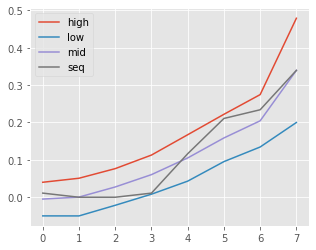

Buy at 0.9827 (2021-11-22 02:20:59.623527)
Waiting until 2021-11-22 02:27:20 local time...


{'iter': 8, 'buy_at': 0.9827, 'sell_at_10th': 0.98, 'gain_at_10th': -0.0027475323089447804, 'sell_time_at_10th': Timestamp('2021-11-22 02:24:00'), 'sell_at_11th': 0.9825, 'gain_at_11th': -0.00020352091177366232, 'sell_time_at_11th': Timestamp('2021-11-22 02:27:00'), 'buy_time': Timestamp('2021-11-22 02:18:00'), 'buy_time_exact': Timestamp('2021-11-22 02:20:59.623527'), 'unblock_time': Timestamp('2021-11-22 02:27:20')}

New search started on freq=[1, 3, 5, 15]...

('FIS', 'USDT', 5, 0.023964532746491993)


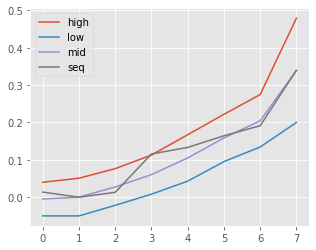

Buy at 1.9233 (2021-11-22 02:39:23.056412)
Waiting until 2021-11-22 02:50:20 local time...


{'iter': 9, 'buy_at': 1.9233, 'sell_at_10th': 1.849, 'gain_at_10th': -0.038631518743825734, 'sell_time_at_10th': Timestamp('2021-11-22 02:45:00'), 'sell_at_11th': 1.8197, 'gain_at_11th': -0.053865751572817505, 'sell_time_at_11th': Timestamp('2021-11-22 02:50:00'), 'buy_time': Timestamp('2021-11-22 02:35:00'), 'buy_time_exact': Timestamp('2021-11-22 02:39:23.056412'), 'unblock_time': Timestamp('2021-11-22 02:50:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('GBP', 1), ('WNXM', 1), ('UNIUP', 1), ('SUSD', 1), ('SUSD', 3), ('SUSD', 5), ('RIF', 1), ('GNO', 1), ('GNO', 3)]
New search started on freq=[1, 3, 5, 15]...

('IOTA', 'USDT', 3, 0.02001664437132489)


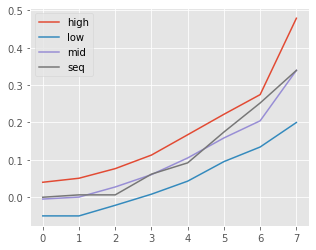

Buy at 1.3709 (2021-11-22 03:07:11.347461)
Waiting until 2021-11-22 03:15:20 local time...


{'iter': 10, 'buy_at': 1.3709, 'sell_at_10th': 1.389, 'gain_at_10th': 0.013203005324969002, 'sell_time_at_10th': Timestamp('2021-11-22 03:12:00'), 'sell_at_11th': 1.3937, 'gain_at_11th': 0.01663141002261283, 'sell_time_at_11th': Timestamp('2021-11-22 03:15:00'), 'buy_time': Timestamp('2021-11-22 03:06:00'), 'buy_time_exact': Timestamp('2021-11-22 03:07:11.347461'), 'unblock_time': Timestamp('2021-11-22 03:15:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('GXS', 1), ('NMR', 1), ('NMR', 3), ('UNIDOWN', 1), ('SUSD', 1), ('SUSD', 3), ('SUSD', 5), ('JUV', 1), ('MLN', 1), ('USDP', 1)]
New search started on freq=[1, 3, 5, 15]...

('ICX', 'USDT', 1, 0.024558906134876997)


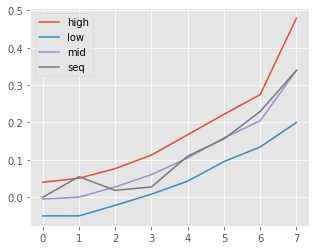

Buy at 2.389 (2021-11-22 03:33:39.177951)
Waiting until 2021-11-22 03:36:20 local time...


{'iter': 11, 'buy_at': 2.389, 'sell_at_10th': 2.389, 'gain_at_10th': 0.0, 'sell_time_at_10th': Timestamp('2021-11-22 03:35:00'), 'sell_at_11th': 2.372, 'gain_at_11th': -0.007115948095437382, 'sell_time_at_11th': Timestamp('2021-11-22 03:36:00'), 'buy_time': Timestamp('2021-11-22 03:33:00'), 'buy_time_exact': Timestamp('2021-11-22 03:33:39.177951'), 'unblock_time': Timestamp('2021-11-22 03:36:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('YFIUP', 1), ('SUSD', 1), ('SUSD', 3), ('SUSD', 5)]
New search started on freq=[1, 3, 5, 15]...

('LAZIO', 'USDT', 15, 0.028133507053993277)


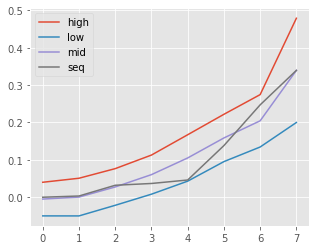

Buy at 6.9081 (2021-11-22 04:09:30.611177)
Waiting until 2021-11-22 04:45:20 local time...


{'iter': 12, 'buy_at': 6.9081, 'sell_at_10th': 6.85, 'gain_at_10th': -0.008410416757140238, 'sell_time_at_10th': Timestamp('2021-11-22 04:30:00'), 'sell_at_11th': 6.7098, 'gain_at_11th': -0.0287054327528553, 'sell_time_at_11th': Timestamp('2021-11-22 04:45:00'), 'buy_time': Timestamp('2021-11-22 04:00:00'), 'buy_time_exact': Timestamp('2021-11-22 04:09:30.611177'), 'unblock_time': Timestamp('2021-11-22 04:45:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('POLS', 1), ('QUICK', 1), ('ELF', 1), ('USDP', 1)]
New search started on freq=[1, 3, 5, 15]...

('BURGER', 'USDT', 1, 0.018951714781746704)


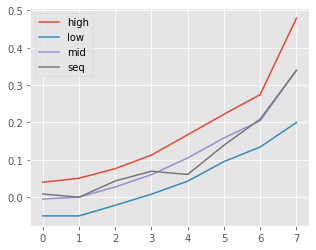

Buy at 3.844 (2021-11-22 05:15:03.896641)
Waiting until 2021-11-22 05:17:20 local time...


{'iter': 13, 'buy_at': 3.844, 'sell_at_10th': 3.846, 'gain_at_10th': 0.0005202913631634298, 'sell_time_at_10th': Timestamp('2021-11-22 05:16:00'), 'sell_at_11th': 3.842, 'gain_at_11th': -0.0005202913631633142, 'sell_time_at_11th': Timestamp('2021-11-22 05:17:00'), 'buy_time': Timestamp('2021-11-22 05:14:00'), 'buy_time_exact': Timestamp('2021-11-22 05:15:03.896641'), 'unblock_time': Timestamp('2021-11-22 05:17:20')}

New search started on freq=[1, 3, 5, 15]...

('ILV', 'USDT', 3, 0.026868250200421363)


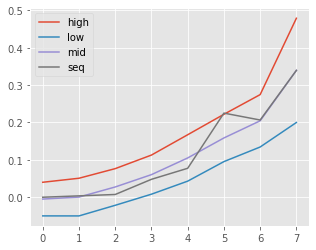

Buy at 1036.3 (2021-11-22 05:32:31.436766)
Waiting until 2021-11-22 05:39:20 local time...


{'iter': 14, 'buy_at': 1036.3, 'sell_at_10th': 1036.9, 'gain_at_10th': 0.0005789829200039915, 'sell_time_at_10th': Timestamp('2021-11-22 05:36:00'), 'sell_at_11th': 1036.5, 'gain_at_11th': 0.0001929943066679972, 'sell_time_at_11th': Timestamp('2021-11-22 05:39:00'), 'buy_time': Timestamp('2021-11-22 05:30:00'), 'buy_time_exact': Timestamp('2021-11-22 05:32:31.436766'), 'unblock_time': Timestamp('2021-11-22 05:39:20')}

New search started on freq=[1, 3, 5, 15]...

('STPT', 'USDT', 5, 0.02053692556490723)


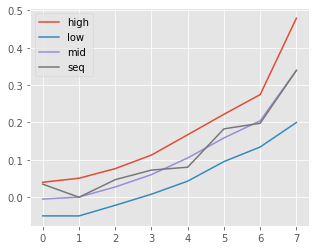

Buy at 0.16544 (2021-11-22 05:44:06.662539)
Waiting until 2021-11-22 05:55:20 local time...


{'iter': 15, 'buy_at': 0.16544, 'sell_at_10th': 0.16449, 'gain_at_10th': -0.005742263056092882, 'sell_time_at_10th': Timestamp('2021-11-22 05:50:00'), 'sell_at_11th': 0.16435, 'gain_at_11th': -0.00658849129593815, 'sell_time_at_11th': Timestamp('2021-11-22 05:55:00'), 'buy_time': Timestamp('2021-11-22 05:40:00'), 'buy_time_exact': Timestamp('2021-11-22 05:44:06.662539'), 'unblock_time': Timestamp('2021-11-22 05:55:20')}

New search started on freq=[1, 3, 5, 15]...

('FORTH', 'USDT', 1, 0.022250114307174565)


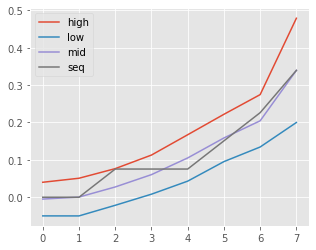

Buy at 13.54 (2021-11-22 06:08:04.438766)
Waiting until 2021-11-22 06:10:20 local time...


{'iter': 16, 'buy_at': 13.54, 'sell_at_10th': 13.61, 'gain_at_10th': 0.0051698670605613214, 'sell_time_at_10th': Timestamp('2021-11-22 06:09:00'), 'sell_at_11th': 13.6, 'gain_at_11th': 0.004431314623338294, 'sell_time_at_11th': Timestamp('2021-11-22 06:10:00'), 'buy_time': Timestamp('2021-11-22 06:07:00'), 'buy_time_exact': Timestamp('2021-11-22 06:08:04.438766'), 'unblock_time': Timestamp('2021-11-22 06:10:20')}

New search started on freq=[1, 3, 5, 15]...

('WAN', 'USDT', 1, 0.02495714883331203)


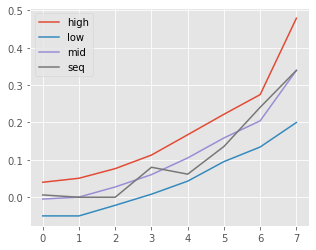

Buy at 0.8931 (2021-11-22 06:13:04.291369)
Waiting until 2021-11-22 06:16:20 local time...


{'iter': 17, 'buy_at': 0.8931, 'sell_at_10th': 0.8916, 'gain_at_10th': -0.001679543164259385, 'sell_time_at_10th': Timestamp('2021-11-22 06:15:00'), 'sell_at_11th': 0.8921, 'gain_at_11th': -0.0011196954428395486, 'sell_time_at_11th': Timestamp('2021-11-22 06:16:00'), 'buy_time': Timestamp('2021-11-22 06:13:00'), 'buy_time_exact': Timestamp('2021-11-22 06:13:04.291369'), 'unblock_time': Timestamp('2021-11-22 06:16:20')}

New search started on freq=[1, 3, 5, 15]...

('NULS', 'USDT', 3, 0.027990111675975673)


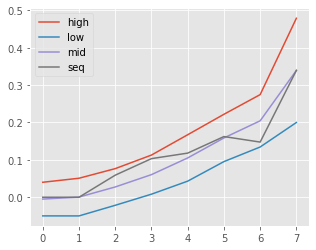

Buy at 0.5253 (2021-11-22 06:17:19.093552)
Waiting until 2021-11-22 06:24:20 local time...


{'iter': 18, 'buy_at': 0.5253, 'sell_at_10th': 0.5246, 'gain_at_10th': -0.0013325718636969996, 'sell_time_at_10th': Timestamp('2021-11-22 06:21:00'), 'sell_at_11th': 0.5246, 'gain_at_11th': -0.0013325718636969996, 'sell_time_at_11th': Timestamp('2021-11-22 06:24:00'), 'buy_time': Timestamp('2021-11-22 06:15:00'), 'buy_time_exact': Timestamp('2021-11-22 06:17:19.093552'), 'unblock_time': Timestamp('2021-11-22 06:24:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('XTZDOWN', 1), ('WNXM', 1), ('XLMUP', 1), ('GNO', 1), ('USDP', 1), ('USDP', 3)]
New search started on freq=[1, 3, 5, 15]...

('CITY', 'USDT', 15, 0.02913578996674748)


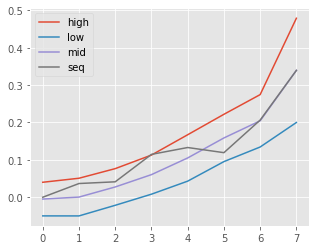

Buy at 13.81 (2021-11-22 06:56:43.146077)
Waiting until 2021-11-22 07:30:20 local time...


{'iter': 19, 'buy_at': 13.81, 'sell_at_10th': 13.62, 'gain_at_10th': -0.01375814627081834, 'sell_time_at_10th': Timestamp('2021-11-22 07:15:00'), 'sell_at_11th': 13.58, 'gain_at_11th': -0.01665459811730633, 'sell_time_at_11th': Timestamp('2021-11-22 07:30:00'), 'buy_time': Timestamp('2021-11-22 06:45:00'), 'buy_time_exact': Timestamp('2021-11-22 06:56:43.146077'), 'unblock_time': Timestamp('2021-11-22 07:30:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('BCHUP', 1), ('BCHDOWN', 1), ('BCHDOWN', 3), ('BCHDOWN', 5), ('SUSD', 1), ('XLMDOWN', 1), ('USDP', 1), ('USDP', 3)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('USDC', 1), ('WNXM', 1), ('XLMDOWN', 1), ('GNO', 1)]
New search started on freq=[1, 3, 5, 15]...

('MFT', 'USDT', 15, 0.02430524094164411)


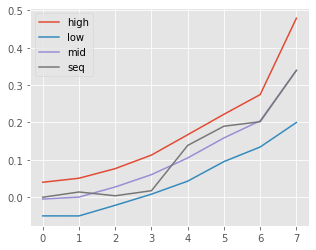

Buy at 0.015 (2021-11-22 08:06:33.321141)
Waiting until 2021-11-22 08:45:20 local time...


{'iter': 20, 'buy_at': 0.015, 'sell_at_10th': 0.015018, 'gain_at_10th': 0.0012000000000000437, 'sell_time_at_10th': Timestamp('2021-11-22 08:30:00'), 'sell_at_11th': 0.01494, 'gain_at_11th': -0.003999999999999953, 'sell_time_at_11th': Timestamp('2021-11-22 08:45:00'), 'buy_time': Timestamp('2021-11-22 08:00:00'), 'buy_time_exact': Timestamp('2021-11-22 08:06:33.321141'), 'unblock_time': Timestamp('2021-11-22 08:45:20')}

New search started on freq=[1, 3, 5, 15]...

('MFT', 'USDT', 1, 0.029550272532265987)


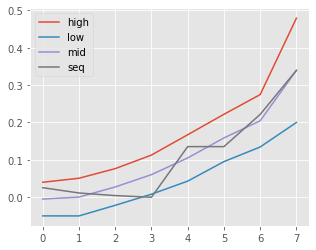

Buy at 0.015332 (2021-11-22 08:48:46.896726)
Waiting until 2021-11-22 08:51:20 local time...


{'iter': 21, 'buy_at': 0.015332, 'sell_at_10th': 0.015366, 'gain_at_10th': 0.0022175841377510635, 'sell_time_at_10th': Timestamp('2021-11-22 08:50:00'), 'sell_at_11th': 0.015179, 'gain_at_11th': -0.009979128619880012, 'sell_time_at_11th': Timestamp('2021-11-22 08:51:00'), 'buy_time': Timestamp('2021-11-22 08:48:00'), 'buy_time_exact': Timestamp('2021-11-22 08:48:46.896726'), 'unblock_time': Timestamp('2021-11-22 08:51:20')}

New search started on freq=[1, 3, 5, 15]...

('ENS', 'USDT', 15, 0.028121088394492115)


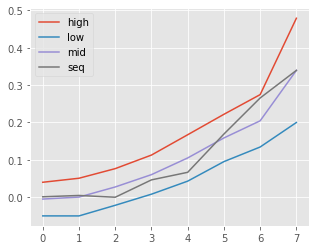

Buy at 44.45 (2021-11-22 09:07:23.360235)
Waiting until 2021-11-22 09:45:20 local time...


{'iter': 22, 'buy_at': 44.45, 'sell_at_10th': 43.3, 'gain_at_10th': -0.02587176602924647, 'sell_time_at_10th': Timestamp('2021-11-22 09:30:00'), 'sell_at_11th': 44.32, 'gain_at_11th': -0.00292463442069747, 'sell_time_at_11th': Timestamp('2021-11-22 09:45:00'), 'buy_time': Timestamp('2021-11-22 09:00:00'), 'buy_time_exact': Timestamp('2021-11-22 09:07:23.360235'), 'unblock_time': Timestamp('2021-11-22 09:45:20')}

New search started on freq=[1, 3, 5, 15]...

('KP3R', 'USDT', 1, 0.021917033803231064)


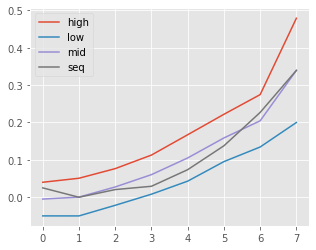

Buy at 1365.25 (2021-11-22 10:21:04.792004)
Waiting until 2021-11-22 10:23:20 local time...


{'iter': 23, 'buy_at': 1365.25, 'sell_at_10th': 1349.22, 'gain_at_10th': -0.011741439296832062, 'sell_time_at_10th': Timestamp('2021-11-22 10:22:00'), 'sell_at_11th': 1344.72, 'gain_at_11th': -0.015037538912287107, 'sell_time_at_11th': Timestamp('2021-11-22 10:23:00'), 'buy_time': Timestamp('2021-11-22 10:20:00'), 'buy_time_exact': Timestamp('2021-11-22 10:21:04.792004'), 'unblock_time': Timestamp('2021-11-22 10:23:20')}

New search started on freq=[1, 3, 5, 15]...

('CFX', 'USDT', 3, 0.027024742524454578)


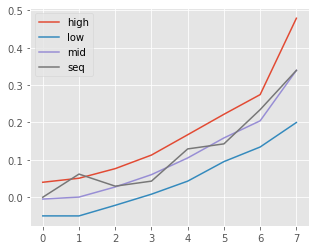

Buy at 0.3305 (2021-11-22 10:35:11.065955)
Waiting until 2021-11-22 10:42:20 local time...


{'iter': 24, 'buy_at': 0.3305, 'sell_at_10th': 0.3296, 'gain_at_10th': -0.002723146747352532, 'sell_time_at_10th': Timestamp('2021-11-22 10:39:00'), 'sell_at_11th': 0.3272, 'gain_at_11th': -0.009984871406959228, 'sell_time_at_11th': Timestamp('2021-11-22 10:42:00'), 'buy_time': Timestamp('2021-11-22 10:33:00'), 'buy_time_exact': Timestamp('2021-11-22 10:35:11.065955'), 'unblock_time': Timestamp('2021-11-22 10:42:20')}

New search started on freq=[1, 3, 5, 15]...

('IRIS', 'USDT', 1, 0.023392728841028273)


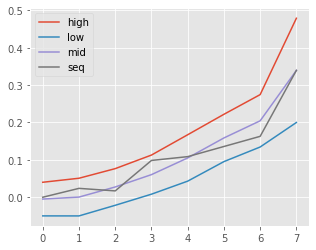

Buy at 0.12133 (2021-11-22 10:49:53.892202)
Waiting until 2021-11-22 10:52:20 local time...


{'iter': 25, 'buy_at': 0.12133, 'sell_at_10th': 0.12092, 'gain_at_10th': -0.003379213714662439, 'sell_time_at_10th': Timestamp('2021-11-22 10:51:00'), 'sell_at_11th': 0.12091, 'gain_at_11th': -0.003461633561361492, 'sell_time_at_11th': Timestamp('2021-11-22 10:52:00'), 'buy_time': Timestamp('2021-11-22 10:49:00'), 'buy_time_exact': Timestamp('2021-11-22 10:49:53.892202'), 'unblock_time': Timestamp('2021-11-22 10:52:20')}

New search started on freq=[1, 3, 5, 15]...

('IOTA', 'USDT', 15, 0.028548491521581936)


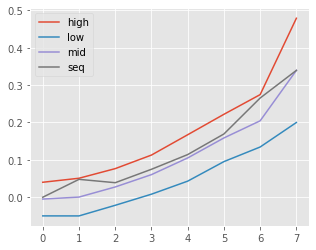

Buy at 1.548 (2021-11-22 11:02:39.946066)
Waiting until 2021-11-22 11:45:20 local time...


{'iter': 26, 'buy_at': 1.548, 'sell_at_10th': 1.5177, 'gain_at_10th': -0.019573643410852708, 'sell_time_at_10th': Timestamp('2021-11-22 11:30:00'), 'sell_at_11th': 1.4842, 'gain_at_11th': -0.041214470284237775, 'sell_time_at_11th': Timestamp('2021-11-22 11:45:00'), 'buy_time': Timestamp('2021-11-22 11:00:00'), 'buy_time_exact': Timestamp('2021-11-22 11:02:39.946066'), 'unblock_time': Timestamp('2021-11-22 11:45:20')}

New search started on freq=[1, 3, 5, 15]...

('KEY', 'USDT', 1, 0.022045240298974544)


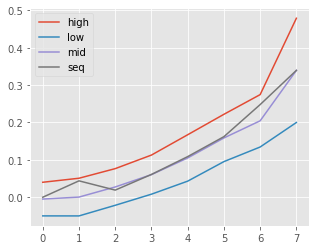

Buy at 0.016407 (2021-11-22 11:48:40.071338)
Waiting until 2021-11-22 11:51:20 local time...


{'iter': 27, 'buy_at': 0.016407, 'sell_at_10th': 0.016456, 'gain_at_10th': 0.0029865301395743866, 'sell_time_at_10th': Timestamp('2021-11-22 11:50:00'), 'sell_at_11th': 0.016489, 'gain_at_11th': 0.004997866764185941, 'sell_time_at_11th': Timestamp('2021-11-22 11:51:00'), 'buy_time': Timestamp('2021-11-22 11:48:00'), 'buy_time_exact': Timestamp('2021-11-22 11:48:40.071338'), 'unblock_time': Timestamp('2021-11-22 11:51:20')}

New search started on freq=[1, 3, 5, 15]...

('ADADOWN', 'USDT', 1, 0.024163929667020786)


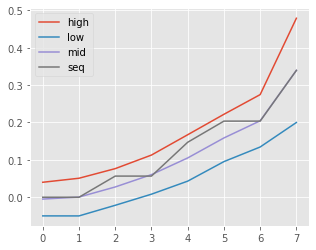

Buy at 0.004616 (2021-11-22 11:57:07.358889)
Waiting until 2021-11-22 11:59:20 local time...


{'iter': 28, 'buy_at': 0.004616, 'sell_at_10th': 0.004617, 'gain_at_10th': 0.00021663778162895695, 'sell_time_at_10th': Timestamp('2021-11-22 11:58:00'), 'sell_at_11th': 0.004617, 'gain_at_11th': 0.00021663778162895695, 'sell_time_at_11th': Timestamp('2021-11-22 11:59:00'), 'buy_time': Timestamp('2021-11-22 11:56:00'), 'buy_time_exact': Timestamp('2021-11-22 11:57:07.358889'), 'unblock_time': Timestamp('2021-11-22 11:59:20')}

New search started on freq=[1, 3, 5, 15]...

('EGLD', 'USDT', 15, 0.022349464394805677)


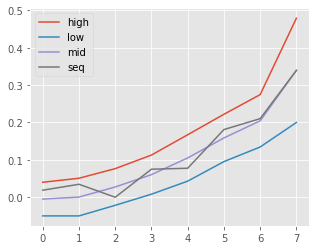

Buy at 489.44 (2021-11-22 12:07:44.796365)
Waiting until 2021-11-22 12:45:20 local time...


{'iter': 29, 'buy_at': 489.44, 'sell_at_10th': 491.74, 'gain_at_10th': 0.004699248120300775, 'sell_time_at_10th': Timestamp('2021-11-22 12:30:00'), 'sell_at_11th': 485.26, 'gain_at_11th': -0.008540372670807468, 'sell_time_at_11th': Timestamp('2021-11-22 12:45:00'), 'buy_time': Timestamp('2021-11-22 12:00:00'), 'buy_time_exact': Timestamp('2021-11-22 12:07:44.796365'), 'unblock_time': Timestamp('2021-11-22 12:45:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('TUSD', 1), ('JUV', 1), ('ATM', 1), ('USDP', 1)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('SUSD', 1), ('USDP', 1), ('USDP', 3), ('USDP', 5)]
New search started on freq=[1, 3, 5, 15]...

('YFIUP', 'USDT', 1, 0.015887701080923133)


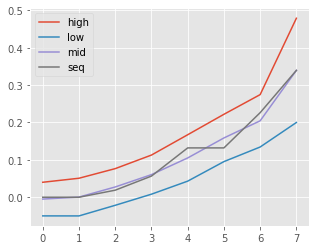

Buy at 0.139 (2021-11-22 13:29:56.560450)
Waiting until 2021-11-22 13:32:20 local time...


{'iter': 30, 'buy_at': 0.139, 'sell_at_10th': 0.139, 'gain_at_10th': 0.0, 'sell_time_at_10th': Timestamp('2021-11-22 13:31:00'), 'sell_at_11th': 0.139, 'gain_at_11th': 0.0, 'sell_time_at_11th': Timestamp('2021-11-22 13:32:00'), 'buy_time': Timestamp('2021-11-22 13:29:00'), 'buy_time_exact': Timestamp('2021-11-22 13:29:56.560450'), 'unblock_time': Timestamp('2021-11-22 13:32:20')}

New search started on freq=[1, 3, 5, 15]...

('MTL', 'USDT', 3, 0.028854367276456586)


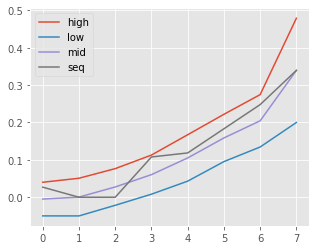

Buy at 3.049 (2021-11-22 13:35:09.557132)
Waiting until 2021-11-22 13:42:20 local time...


{'iter': 31, 'buy_at': 3.049, 'sell_at_10th': 3.073, 'gain_at_10th': 0.007871433256805517, 'sell_time_at_10th': Timestamp('2021-11-22 13:39:00'), 'sell_at_11th': 3.082, 'gain_at_11th': 0.01082322072810755, 'sell_time_at_11th': Timestamp('2021-11-22 13:42:00'), 'buy_time': Timestamp('2021-11-22 13:33:00'), 'buy_time_exact': Timestamp('2021-11-22 13:35:09.557132'), 'unblock_time': Timestamp('2021-11-22 13:42:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('EUR', 15), ('SUSD', 1), ('SUSD', 3), ('SUSD', 5)]
New search started on freq=[1, 3, 5, 15]...

('XRPDOWN', 'USDT', 1, 0.02823662096329451)


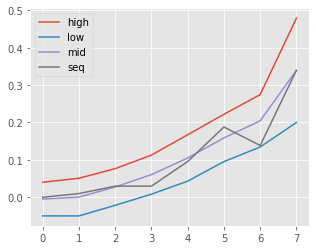

Buy at 0.0011196 (2021-11-22 14:08:32.650841)
Waiting until 2021-11-22 14:11:20 local time...


{'iter': 32, 'buy_at': 0.0011196, 'sell_at_10th': 0.0011121, 'gain_at_10th': -0.006698821007502601, 'sell_time_at_10th': Timestamp('2021-11-22 14:10:00'), 'sell_at_11th': 0.0011105, 'gain_at_11th': -0.00812790282243654, 'sell_time_at_11th': Timestamp('2021-11-22 14:11:00'), 'buy_time': Timestamp('2021-11-22 14:08:00'), 'buy_time_exact': Timestamp('2021-11-22 14:08:32.650841'), 'unblock_time': Timestamp('2021-11-22 14:11:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('EUR', 1), ('AUCTION', 1)]
New search started on freq=[1, 3, 5, 15]...

('SYS', 'USDT', 3, 0.012113998596808834)


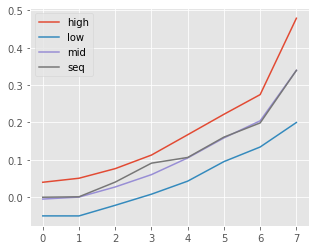

Buy at 0.518 (2021-11-22 14:43:59.776618)
Waiting until 2021-11-22 14:51:20 local time...


{'iter': 33, 'buy_at': 0.518, 'sell_at_10th': 0.5081, 'gain_at_10th': -0.01911196911196915, 'sell_time_at_10th': Timestamp('2021-11-22 14:48:00'), 'sell_at_11th': 0.5068, 'gain_at_11th': -0.0216216216216216, 'sell_time_at_11th': Timestamp('2021-11-22 14:51:00'), 'buy_time': Timestamp('2021-11-22 14:42:00'), 'buy_time_exact': Timestamp('2021-11-22 14:43:59.776618'), 'unblock_time': Timestamp('2021-11-22 14:51:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('EOSUP', 1), ('SUSD', 1)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('XRPDOWN', 1), ('BCHDOWN', 1), ('SUSD', 1), ('SUSD', 3), ('GNO', 1)]
New search started on freq=[1, 3, 5, 15]...

('QNT', 'USDT', 3, 0.029817102454023265)


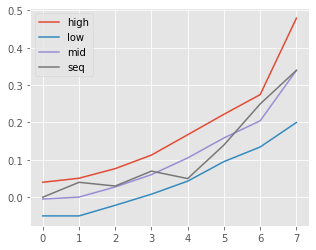

Buy at 222.5 (2021-11-22 15:38:53.899777)
Waiting until 2021-11-22 15:45:20 local time...


{'iter': 34, 'buy_at': 222.5, 'sell_at_10th': 222.4, 'gain_at_10th': -0.00044943820224716544, 'sell_time_at_10th': Timestamp('2021-11-22 15:42:00'), 'sell_at_11th': 222.2, 'gain_at_11th': -0.0013483146067416242, 'sell_time_at_11th': Timestamp('2021-11-22 15:45:00'), 'buy_time': Timestamp('2021-11-22 15:36:00'), 'buy_time_exact': Timestamp('2021-11-22 15:38:53.899777'), 'unblock_time': Timestamp('2021-11-22 15:45:20')}

New search started on freq=[1, 3, 5, 15]...

('AVAX', 'USDT', 15, 0.027076522867647192)


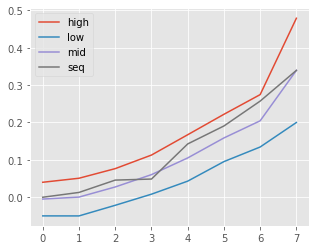

Buy at 138.61 (2021-11-22 15:54:24.605864)
Waiting until 2021-11-22 16:30:20 local time...


{'iter': 35, 'buy_at': 138.61, 'sell_at_10th': 142.74, 'gain_at_10th': 0.029795830026693566, 'sell_time_at_10th': Timestamp('2021-11-22 16:15:00'), 'sell_at_11th': 141.07, 'gain_at_11th': 0.017747637255609114, 'sell_time_at_11th': Timestamp('2021-11-22 16:30:00'), 'buy_time': Timestamp('2021-11-22 15:45:00'), 'buy_time_exact': Timestamp('2021-11-22 15:54:24.605864'), 'unblock_time': Timestamp('2021-11-22 16:30:20')}

New search started on freq=[1, 3, 5, 15]...

('PNT', 'USDT', 15, 0.021577802018925805)


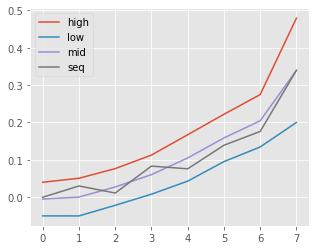

Buy at 1.1998 (2021-11-22 16:36:03.955823)
Waiting until 2021-11-22 17:15:20 local time...


{'iter': 36, 'buy_at': 1.1998, 'sell_at_10th': 1.1543, 'gain_at_10th': -0.037922987164527314, 'sell_time_at_10th': Timestamp('2021-11-22 17:00:00'), 'sell_at_11th': 1.149, 'gain_at_11th': -0.0423403900650108, 'sell_time_at_11th': Timestamp('2021-11-22 17:15:00'), 'buy_time': Timestamp('2021-11-22 16:30:00'), 'buy_time_exact': Timestamp('2021-11-22 16:36:03.955823'), 'unblock_time': Timestamp('2021-11-22 17:15:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('XTZDOWN', 1), ('UNIDOWN', 1), ('BCHDOWN', 3), ('SUSD', 1), ('RIF', 1), ('REQ', 1), ('GNO', 1), ('USDP', 1), ('USDP', 3), ('USDP', 5)]
New search started on freq=[1, 3, 5, 15]...

('STPT', 'USDT', 5, 0.01904998164085326)


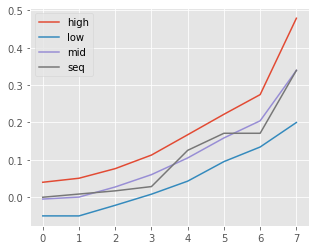

Buy at 0.15379 (2021-11-22 17:37:23.889141)
Waiting until 2021-11-22 17:50:20 local time...


{'iter': 37, 'buy_at': 0.15379, 'sell_at_10th': 0.15352, 'gain_at_10th': -0.0017556408088953781, 'sell_time_at_10th': Timestamp('2021-11-22 17:45:00'), 'sell_at_11th': 0.15242, 'gain_at_11th': -0.008908251511801872, 'sell_time_at_11th': Timestamp('2021-11-22 17:50:00'), 'buy_time': Timestamp('2021-11-22 17:35:00'), 'buy_time_exact': Timestamp('2021-11-22 17:37:23.889141'), 'unblock_time': Timestamp('2021-11-22 17:50:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('BNBUP', 1), ('NMR', 1), ('YFIUP', 1), ('BCHDOWN', 1), ('SUSD', 1), ('XLMDOWN', 1), ('RIF', 1), ('USDP', 1), ('CITY', 1)]
New search started on freq=[1, 3, 5, 15]...

('FRONT', 'USDT', 5, 0.02593997893087295)


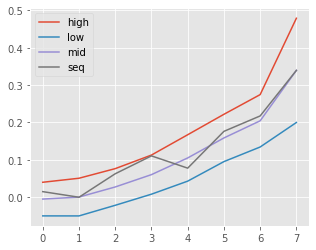

Buy at 1.1584 (2021-11-22 18:22:45.804152)
Waiting until 2021-11-22 18:35:20 local time...


{'iter': 38, 'buy_at': 1.1584, 'sell_at_10th': 1.1463, 'gain_at_10th': -0.010445441988950276, 'sell_time_at_10th': Timestamp('2021-11-22 18:30:00'), 'sell_at_11th': 1.1699, 'gain_at_11th': 0.009927486187845167, 'sell_time_at_11th': Timestamp('2021-11-22 18:35:00'), 'buy_time': Timestamp('2021-11-22 18:20:00'), 'buy_time_exact': Timestamp('2021-11-22 18:22:45.804152'), 'unblock_time': Timestamp('2021-11-22 18:35:20')}

New search started on freq=[1, 3, 5, 15]...

('BTCDOWN', 'USDT', 5, 0.02523971464088479)


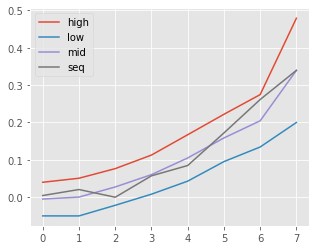

Buy at 0.009165 (2021-11-22 18:41:02.799475)
Waiting until 2021-11-22 18:55:20 local time...


{'iter': 39, 'buy_at': 0.009165, 'sell_at_10th': 0.00917, 'gain_at_10th': 0.0005455537370430766, 'sell_time_at_10th': Timestamp('2021-11-22 18:50:00'), 'sell_at_11th': 0.009186, 'gain_at_11th': 0.002291325695581035, 'sell_time_at_11th': Timestamp('2021-11-22 18:55:00'), 'buy_time': Timestamp('2021-11-22 18:40:00'), 'buy_time_exact': Timestamp('2021-11-22 18:41:02.799475'), 'unblock_time': Timestamp('2021-11-22 18:55:20')}

New search started on freq=[1, 3, 5, 15]...

('ADADOWN', 'USDT', 1, 0.026729415269364003)


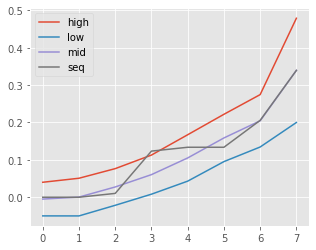

Buy at 0.004771 (2021-11-22 19:01:43.194748)
Waiting until 2021-11-22 19:04:20 local time...


{'iter': 40, 'buy_at': 0.004771, 'sell_at_10th': 0.004722, 'gain_at_10th': -0.010270383567386382, 'sell_time_at_10th': Timestamp('2021-11-22 19:03:00'), 'sell_at_11th': 0.004736, 'gain_at_11th': -0.007335988262418844, 'sell_time_at_11th': Timestamp('2021-11-22 19:04:00'), 'buy_time': Timestamp('2021-11-22 19:01:00'), 'buy_time_exact': Timestamp('2021-11-22 19:01:43.194748'), 'unblock_time': Timestamp('2021-11-22 19:04:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('BCHUP', 1), ('SUSD', 1), ('XLMDOWN', 1), ('USDP', 1)]
New search started on freq=[1, 3, 5, 15]...

Errors: []
New search started on freq=[1, 3, 5, 15]...

Errors: [('SUSD', 1)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('OG', 1), ('USDP', 1), ('BNX', 1)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('YFIDOWN', 1), ('USDP', 1), ('USDP', 3), ('USDP', 5)]
New search started on freq=[1, 3, 5, 15]...

('DASH', 'USDT', 1, 0.02882168150862616)


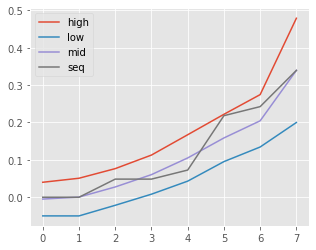

Buy at 192.3 (2021-11-22 20:33:39.254160)
Waiting until 2021-11-22 20:36:20 local time...


{'iter': 41, 'buy_at': 192.3, 'sell_at_10th': 192.3, 'gain_at_10th': 0.0, 'sell_time_at_10th': Timestamp('2021-11-22 20:35:00'), 'sell_at_11th': 192.2, 'gain_at_11th': -0.0005200208008321515, 'sell_time_at_11th': Timestamp('2021-11-22 20:36:00'), 'buy_time': Timestamp('2021-11-22 20:33:00'), 'buy_time_exact': Timestamp('2021-11-22 20:33:39.254160'), 'unblock_time': Timestamp('2021-11-22 20:36:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('USDC', 15), ('EUR', 5), ('ADADOWN', 1), ('FILUP', 1), ('BCHDOWN', 1), ('XLMDOWN', 1), ('USDP', 1), ('USDP', 3), ('USDP', 5)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('TUSD', 3), ('SUSD', 1)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('DCR', 1), ('SUSD', 1), ('USDP', 1)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('USDC', 15), ('GNO', 1), ('USDP', 1), ('USDP', 3)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('EUR', 1), ('BCHUP', 1), ('BCHDOWN', 1), ('SUSD', 1), ('SUSD', 3), ('RIF', 1), ('GN

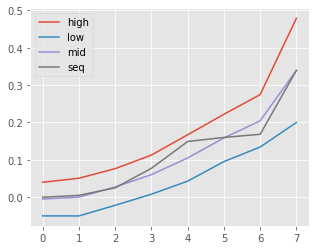

Buy at 0.10356 (2021-11-22 22:05:23.103418)
Waiting until 2021-11-22 22:12:20 local time...


{'iter': 42, 'buy_at': 0.10356, 'sell_at_10th': 0.10541, 'gain_at_10th': 0.01786404016994983, 'sell_time_at_10th': Timestamp('2021-11-22 22:09:00'), 'sell_at_11th': 0.10393, 'gain_at_11th': 0.0035728080339899127, 'sell_time_at_11th': Timestamp('2021-11-22 22:12:00'), 'buy_time': Timestamp('2021-11-22 22:03:00'), 'buy_time_exact': Timestamp('2021-11-22 22:05:23.103418'), 'unblock_time': Timestamp('2021-11-22 22:12:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('BCHDOWN', 1), ('SUSD', 1), ('SUSD', 3), ('SUSD', 5), ('XLMDOWN', 1), ('MLN', 1), ('QUICK', 1), ('USDP', 1), ('USDP', 3), ('USDP', 5)]
New search started on freq=[1, 3, 5, 15]...

('GRT', 'USDT', 1, 0.022297862677576434)


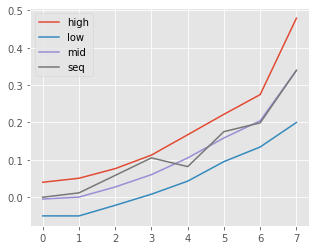

Buy at 0.8762 (2021-11-22 22:39:59.489199)
Waiting until 2021-11-22 22:42:20 local time...


{'iter': 43, 'buy_at': 0.8762, 'sell_at_10th': 0.8773, 'gain_at_10th': 0.0012554211367267632, 'sell_time_at_10th': Timestamp('2021-11-22 22:41:00'), 'sell_at_11th': 0.8777, 'gain_at_11th': 0.001711937913718394, 'sell_time_at_11th': Timestamp('2021-11-22 22:42:00'), 'buy_time': Timestamp('2021-11-22 22:39:00'), 'buy_time_exact': Timestamp('2021-11-22 22:39:59.489199'), 'unblock_time': Timestamp('2021-11-22 22:42:20')}

New search started on freq=[1, 3, 5, 15]...

('OMG', 'USDT', 3, 0.026524150659003792)


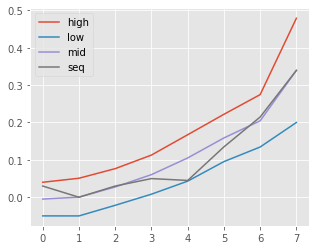

Buy at 9.136 (2021-11-22 22:44:12.255571)
Waiting until 2021-11-22 22:51:20 local time...


{'iter': 44, 'buy_at': 9.136, 'sell_at_10th': 9.139, 'gain_at_10th': 0.0003283712784588566, 'sell_time_at_10th': Timestamp('2021-11-22 22:48:00'), 'sell_at_11th': 9.127, 'gain_at_11th': -0.0009851138353763754, 'sell_time_at_11th': Timestamp('2021-11-22 22:51:00'), 'buy_time': Timestamp('2021-11-22 22:42:00'), 'buy_time_exact': Timestamp('2021-11-22 22:44:12.255571'), 'unblock_time': Timestamp('2021-11-22 22:51:20')}

New search started on freq=[1, 3, 5, 15]...

('STORJ', 'USDT', 5, 0.014500988708520762)


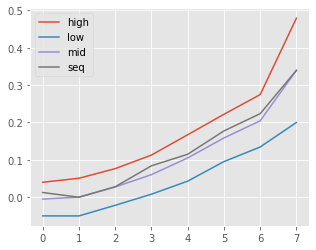

Buy at 1.9536 (2021-11-22 22:58:19.417218)
Waiting until 2021-11-22 23:10:20 local time...


{'iter': 45, 'buy_at': 1.9536, 'sell_at_10th': 1.9526, 'gain_at_10th': -0.0005118755118755691, 'sell_time_at_10th': Timestamp('2021-11-22 23:05:00'), 'sell_at_11th': 1.9387, 'gain_at_11th': -0.0076269451269450825, 'sell_time_at_11th': Timestamp('2021-11-22 23:10:00'), 'buy_time': Timestamp('2021-11-22 22:55:00'), 'buy_time_exact': Timestamp('2021-11-22 22:58:19.417218'), 'unblock_time': Timestamp('2021-11-22 23:10:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('TUSD', 3), ('BUSD', 5), ('SUSD', 1), ('XLMDOWN', 1), ('OG', 1), ('GNO', 1), ('GNO', 3)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('TUSD', 1), ('GXS', 1), ('NMR', 1), ('YFIDOWN', 1), ('YFIDOWN', 3), ('SUSD', 1), ('XLMDOWN', 1), ('ATM', 1), ('MLN', 1), ('GNO', 1), ('CVP', 1)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('FILDOWN', 1), ('YFIUP', 1), ('STRAX', 1), ('OG', 1), ('BAR', 1), ('FORTH', 1), ('BOND', 1), ('USDP', 1)]
New search started on freq=[1, 3, 5, 15]...

('MANA', 'USDT', 15, 0.02

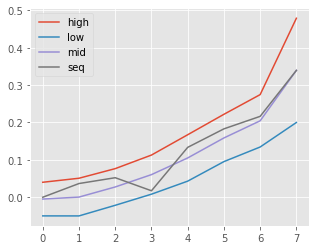

Buy at 4.182 (2021-11-23 00:10:10.719439)
Waiting until 2021-11-23 00:45:20 local time...


{'iter': 46, 'buy_at': 4.182, 'sell_at_10th': 4.1298, 'gain_at_10th': -0.012482065997130564, 'sell_time_at_10th': Timestamp('2021-11-23 00:30:00'), 'sell_at_11th': 4.137, 'gain_at_11th': -0.01076040172166447, 'sell_time_at_11th': Timestamp('2021-11-23 00:45:00'), 'buy_time': Timestamp('2021-11-23 00:00:00'), 'buy_time_exact': Timestamp('2021-11-23 00:10:10.719439'), 'unblock_time': Timestamp('2021-11-23 00:45:20')}

New search started on freq=[1, 3, 5, 15]...

('LIT', 'USDT', 3, 0.0228834912271028)


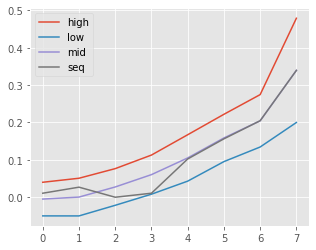

Buy at 4.45 (2021-11-23 00:58:09.626553)
Waiting until 2021-11-23 01:06:20 local time...


{'iter': 47, 'buy_at': 4.45, 'sell_at_10th': 4.587, 'gain_at_10th': 0.030786516853932487, 'sell_time_at_10th': Timestamp('2021-11-23 01:03:00'), 'sell_at_11th': 4.576, 'gain_at_11th': 0.028314606741572906, 'sell_time_at_11th': Timestamp('2021-11-23 01:06:00'), 'buy_time': Timestamp('2021-11-23 00:57:00'), 'buy_time_exact': Timestamp('2021-11-23 00:58:09.626553'), 'unblock_time': Timestamp('2021-11-23 01:06:20')}

New search started on freq=[1, 3, 5, 15]...

('VITE', 'USDT', 1, 0.026609281581506695)


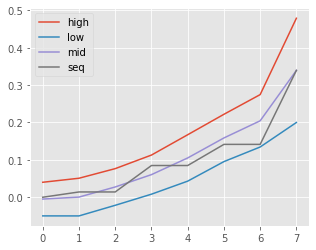

Buy at 0.1129 (2021-11-23 01:10:44.870589)
Waiting until 2021-11-23 01:13:20 local time...


{'iter': 48, 'buy_at': 0.1129, 'sell_at_10th': 0.11272, 'gain_at_10th': -0.0015943312666076139, 'sell_time_at_10th': Timestamp('2021-11-23 01:12:00'), 'sell_at_11th': 0.1129, 'gain_at_11th': 0.0, 'sell_time_at_11th': Timestamp('2021-11-23 01:13:00'), 'buy_time': Timestamp('2021-11-23 01:10:00'), 'buy_time_exact': Timestamp('2021-11-23 01:10:44.870589'), 'unblock_time': Timestamp('2021-11-23 01:13:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('TUSD', 1), ('ARDR', 1), ('SUSD', 1), ('SUSD', 3), ('RIF', 1)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('TUSD', 3), ('GXS', 1), ('MDT', 1), ('NMR', 1), ('TRXDOWN', 1), ('YFIUP', 1), ('XLMDOWN', 1), ('GNO', 1), ('CVP', 1), ('RGT', 1)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('BCHDOWN', 1), ('BCHDOWN', 3), ('SUSD', 1), ('REQ', 1), ('REQ', 3), ('RAD', 1)]
New search started on freq=[1, 3, 5, 15]...

('ROSE', 'USDT', 3, 0.022319682950623893)


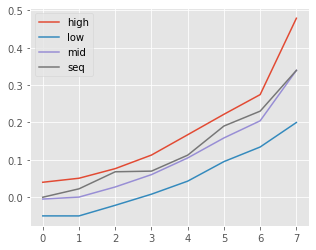

Buy at 0.36542 (2021-11-23 02:16:50.171103)
Waiting until 2021-11-23 02:24:20 local time...


{'iter': 49, 'buy_at': 0.36542, 'sell_at_10th': 0.36362, 'gain_at_10th': -0.004925838760877959, 'sell_time_at_10th': Timestamp('2021-11-23 02:21:00'), 'sell_at_11th': 0.36629, 'gain_at_11th': 0.002380822067757599, 'sell_time_at_11th': Timestamp('2021-11-23 02:24:00'), 'buy_time': Timestamp('2021-11-23 02:15:00'), 'buy_time_exact': Timestamp('2021-11-23 02:16:50.171103'), 'unblock_time': Timestamp('2021-11-23 02:24:20')}

New search started on freq=[1, 3, 5, 15]...

('WIN', 'USDT', 15, 0.0251995674857577)


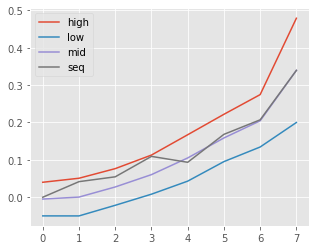

Buy at 0.0008441 (2021-11-23 02:26:44.982041)
Waiting until 2021-11-23 03:00:20 local time...


{'iter': 50, 'buy_at': 0.0008441, 'sell_at_10th': 0.0008461, 'gain_at_10th': 0.0023693875133278626, 'sell_time_at_10th': Timestamp('2021-11-23 02:45:00'), 'sell_at_11th': 0.0008506, 'gain_at_11th': 0.00770050941831536, 'sell_time_at_11th': Timestamp('2021-11-23 03:00:00'), 'buy_time': Timestamp('2021-11-23 02:15:00'), 'buy_time_exact': Timestamp('2021-11-23 02:26:44.982041'), 'unblock_time': Timestamp('2021-11-23 03:00:20')}

New search started on freq=[1, 3, 5, 15]...

('ORN', 'USDT', 15, 0.025876801081859024)


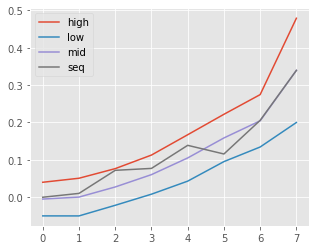

Buy at 7.942 (2021-11-23 03:09:36.611043)
Waiting until 2021-11-23 03:45:20 local time...


{'iter': 51, 'buy_at': 7.942, 'sell_at_10th': 7.93, 'gain_at_10th': -0.0015109544195417344, 'sell_time_at_10th': Timestamp('2021-11-23 03:30:00'), 'sell_at_11th': 7.958, 'gain_at_11th': 0.0020146058927222378, 'sell_time_at_11th': Timestamp('2021-11-23 03:45:00'), 'buy_time': Timestamp('2021-11-23 03:00:00'), 'buy_time_exact': Timestamp('2021-11-23 03:09:36.611043'), 'unblock_time': Timestamp('2021-11-23 03:45:20')}

New search started on freq=[1, 3, 5, 15]...

('WAN', 'USDT', 1, 0.020350561274399978)


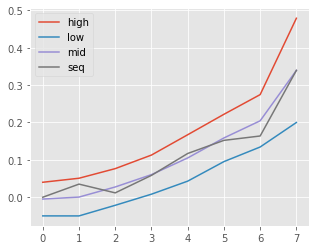

Buy at 0.898 (2021-11-23 03:48:53.451375)
Waiting until 2021-11-23 03:51:20 local time...


{'iter': 52, 'buy_at': 0.898, 'sell_at_10th': 0.896, 'gain_at_10th': -0.002227171492204902, 'sell_time_at_10th': Timestamp('2021-11-23 03:50:00'), 'sell_at_11th': 0.8953, 'gain_at_11th': -0.003006681514476654, 'sell_time_at_11th': Timestamp('2021-11-23 03:51:00'), 'buy_time': Timestamp('2021-11-23 03:48:00'), 'buy_time_exact': Timestamp('2021-11-23 03:48:53.451375'), 'unblock_time': Timestamp('2021-11-23 03:51:20')}

New search started on freq=[1, 3, 5, 15]...

('MIR', 'USDT', 5, 0.024587064461535003)


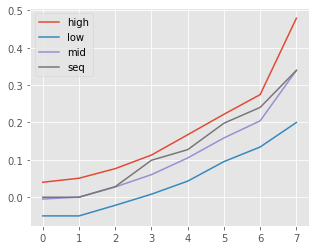

Buy at 2.826 (2021-11-23 04:04:29.091798)
Waiting until 2021-11-23 04:15:20 local time...


{'iter': 53, 'buy_at': 2.826, 'sell_at_10th': 2.816, 'gain_at_10th': -0.003538570417551391, 'sell_time_at_10th': Timestamp('2021-11-23 04:10:00'), 'sell_at_11th': 2.815, 'gain_at_11th': -0.003892427459306483, 'sell_time_at_11th': Timestamp('2021-11-23 04:15:00'), 'buy_time': Timestamp('2021-11-23 04:00:00'), 'buy_time_exact': Timestamp('2021-11-23 04:04:29.091798'), 'unblock_time': Timestamp('2021-11-23 04:15:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('NMR', 1), ('YFIDOWN', 1), ('BCHUP', 1), ('BCHDOWN', 1), ('SUSD', 1), ('SUSD', 3), ('XLMDOWN', 1), ('JUV', 1), ('RIF', 1), ('GNO', 1), ('USDP', 1), ('USDP', 3), ('DF', 1), ('AUCTION', 1)]
New search started on freq=[1, 3, 5, 15]...

('ANT', 'USDT', 3, 0.017792271642188565)


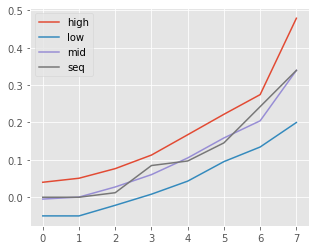

Buy at 4.821 (2021-11-23 04:38:37.202237)
Waiting until 2021-11-23 04:45:20 local time...


{'iter': 54, 'buy_at': 4.821, 'sell_at_10th': 4.797, 'gain_at_10th': -0.004978220286247671, 'sell_time_at_10th': Timestamp('2021-11-23 04:42:00'), 'sell_at_11th': 4.815, 'gain_at_11th': -0.0012445550715617796, 'sell_time_at_11th': Timestamp('2021-11-23 04:45:00'), 'buy_time': Timestamp('2021-11-23 04:36:00'), 'buy_time_exact': Timestamp('2021-11-23 04:38:37.202237'), 'unblock_time': Timestamp('2021-11-23 04:45:20')}

New search started on freq=[1, 3, 5, 15]...

('BEL', 'USDT', 5, 0.026230853896700015)


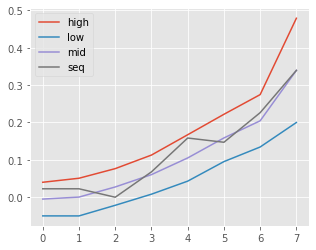

Buy at 2.23 (2021-11-23 04:54:32.697737)
Waiting until 2021-11-23 05:05:20 local time...


{'iter': 55, 'buy_at': 2.23, 'sell_at_10th': 2.223, 'gain_at_10th': -0.003139013452914851, 'sell_time_at_10th': Timestamp('2021-11-23 05:00:00'), 'sell_at_11th': 2.216, 'gain_at_11th': -0.0062780269058295025, 'sell_time_at_11th': Timestamp('2021-11-23 05:05:00'), 'buy_time': Timestamp('2021-11-23 04:50:00'), 'buy_time_exact': Timestamp('2021-11-23 04:54:32.697737'), 'unblock_time': Timestamp('2021-11-23 05:05:20')}

New search started on freq=[1, 3, 5, 15]...

('DATA', 'USDT', 15, 0.022217606922900503)


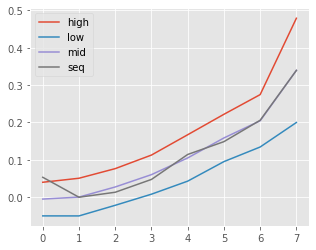

Buy at 0.13699 (2021-11-23 05:10:21.403157)
Waiting until 2021-11-23 05:45:20 local time...


{'iter': 56, 'buy_at': 0.13699, 'sell_at_10th': 0.13583, 'gain_at_10th': -0.008467771370172964, 'sell_time_at_10th': Timestamp('2021-11-23 05:30:00'), 'sell_at_11th': 0.1358, 'gain_at_11th': -0.008686765457332627, 'sell_time_at_11th': Timestamp('2021-11-23 05:45:00'), 'buy_time': Timestamp('2021-11-23 05:00:00'), 'buy_time_exact': Timestamp('2021-11-23 05:10:21.403157'), 'unblock_time': Timestamp('2021-11-23 05:45:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('XTZDOWN', 1), ('YFIUP', 1), ('BCHDOWN', 1), ('STRAX', 1), ('SUSD', 1), ('USDP', 1)]
New search started on freq=[1, 3, 5, 15]...

('BTCST', 'USDT', 5, 0.02812914715958505)


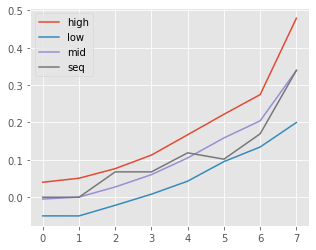

Buy at 32.17 (2021-11-23 06:14:54.454687)
Waiting until 2021-11-23 06:25:20 local time...


{'iter': 57, 'buy_at': 32.17, 'sell_at_10th': 32.24, 'gain_at_10th': 0.0021759403170655976, 'sell_time_at_10th': Timestamp('2021-11-23 06:20:00'), 'sell_at_11th': 32.12, 'gain_at_11th': -0.0015542430836184104, 'sell_time_at_11th': Timestamp('2021-11-23 06:25:00'), 'buy_time': Timestamp('2021-11-23 06:10:00'), 'buy_time_exact': Timestamp('2021-11-23 06:14:54.454687'), 'unblock_time': Timestamp('2021-11-23 06:25:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('TUSD', 1), ('USDC', 1), ('XTZUP', 1), ('BCHDOWN', 1), ('SUSD', 1), ('OG', 1), ('ATM', 1), ('ASR', 1), ('USDP', 1)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('BCHDOWN', 1), ('SUSD', 1), ('SUSD', 3), ('XLMUP', 1), ('GNO', 1)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('EUR', 1), ('NMR', 1), ('BCHDOWN', 1), ('BCHDOWN', 3), ('SUSD', 1), ('SUSD', 3), ('SUSD', 5), ('XLMDOWN', 1), ('RIF', 1), ('GNO', 1), ('GNO', 3), ('USDP', 1)]
New search started on freq=[1, 3, 5, 15]...

('EOSDOWN', 'USDT', 3, 0.02

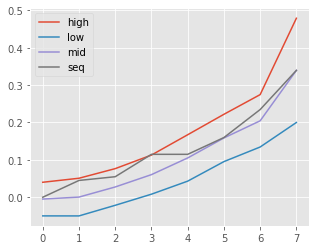

Buy at 0.0004021 (2021-11-23 07:20:52.112646)
Waiting until 2021-11-23 07:27:20 local time...


{'iter': 58, 'buy_at': 0.0004021, 'sell_at_10th': 0.0004034, 'gain_at_10th': 0.0032330266102958897, 'sell_time_at_10th': Timestamp('2021-11-23 07:24:00'), 'sell_at_11th': 0.000402, 'gain_at_11th': -0.00024869435463815574, 'sell_time_at_11th': Timestamp('2021-11-23 07:27:00'), 'buy_time': Timestamp('2021-11-23 07:18:00'), 'buy_time_exact': Timestamp('2021-11-23 07:20:52.112646'), 'unblock_time': Timestamp('2021-11-23 07:27:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('WNXM', 1), ('BCHUP', 1), ('SUSD', 1), ('XLMDOWN', 1)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('XLMDOWN', 1), ('XLMDOWN', 3), ('MLN', 1), ('CVP', 1)]
New search started on freq=[1, 3, 5, 15]...

('KMD', 'USDT', 1, 0.023624801828503978)


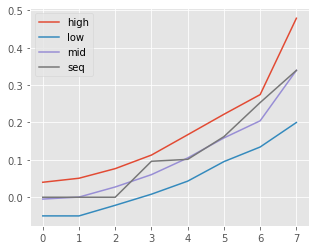

Buy at 0.9427 (2021-11-23 08:06:06.144725)
Waiting until 2021-11-23 08:09:20 local time...


{'iter': 59, 'buy_at': 0.9427, 'sell_at_10th': 0.9422, 'gain_at_10th': -0.000530391428874451, 'sell_time_at_10th': Timestamp('2021-11-23 08:08:00'), 'sell_at_11th': 0.9385, 'gain_at_11th': -0.004455288002545859, 'sell_time_at_11th': Timestamp('2021-11-23 08:09:00'), 'buy_time': Timestamp('2021-11-23 08:06:00'), 'buy_time_exact': Timestamp('2021-11-23 08:06:06.144725'), 'unblock_time': Timestamp('2021-11-23 08:09:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('YFIUP', 1), ('YFIDOWN', 1), ('SUSD', 1), ('AUCTION', 1)]
New search started on freq=[1, 3, 5, 15]...

('LRC', 'USDT', 1, 0.013145100428759942)


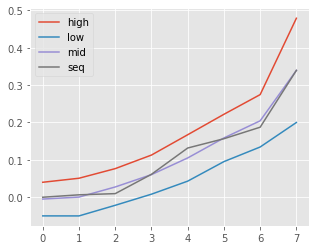

Buy at 2.8471 (2021-11-23 08:31:55.286109)
Waiting until 2021-11-23 08:34:20 local time...


{'iter': 60, 'buy_at': 2.8471, 'sell_at_10th': 2.9407, 'gain_at_10th': 0.032875557584910925, 'sell_time_at_10th': Timestamp('2021-11-23 08:33:00'), 'sell_at_11th': 2.8631, 'gain_at_11th': 0.005619753433318117, 'sell_time_at_11th': Timestamp('2021-11-23 08:34:00'), 'buy_time': Timestamp('2021-11-23 08:31:00'), 'buy_time_exact': Timestamp('2021-11-23 08:31:55.286109'), 'unblock_time': Timestamp('2021-11-23 08:34:20')}

New search started on freq=[1, 3, 5, 15]...

('ALICE', 'USDT', 1, 0.016116160640423007)


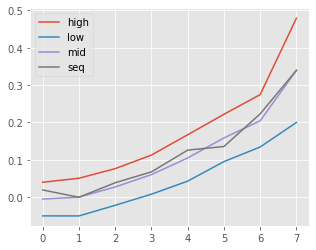

Buy at 22.74 (2021-11-23 08:46:23.591490)
Waiting until 2021-11-23 08:49:20 local time...


{'iter': 61, 'buy_at': 22.74, 'sell_at_10th': 22.55, 'gain_at_10th': -0.008355321020228573, 'sell_time_at_10th': Timestamp('2021-11-23 08:48:00'), 'sell_at_11th': 22.58, 'gain_at_11th': -0.007036059806508362, 'sell_time_at_11th': Timestamp('2021-11-23 08:49:00'), 'buy_time': Timestamp('2021-11-23 08:46:00'), 'buy_time_exact': Timestamp('2021-11-23 08:46:23.591490'), 'unblock_time': Timestamp('2021-11-23 08:49:20')}

New search started on freq=[1, 3, 5, 15]...

('NBS', 'USDT', 3, 0.02040345105111265)


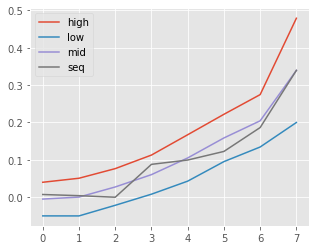

Buy at 0.02623 (2021-11-23 08:57:56.016891)
Waiting until 2021-11-23 09:06:20 local time...


{'iter': 62, 'buy_at': 0.02623, 'sell_at_10th': 0.02576, 'gain_at_10th': -0.017918414029736873, 'sell_time_at_10th': Timestamp('2021-11-23 09:03:00'), 'sell_at_11th': 0.02605, 'gain_at_11th': -0.006862371330537537, 'sell_time_at_11th': Timestamp('2021-11-23 09:06:00'), 'buy_time': Timestamp('2021-11-23 08:57:00'), 'buy_time_exact': Timestamp('2021-11-23 08:57:56.016891'), 'unblock_time': Timestamp('2021-11-23 09:06:20')}

New search started on freq=[1, 3, 5, 15]...

('CTXC', 'USDT', 5, 0.02943539657455983)


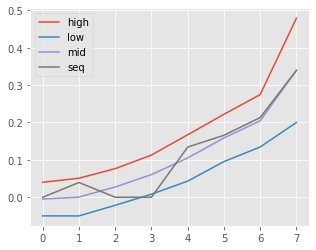

Buy at 0.2159 (2021-11-23 09:10:02.530130)
Waiting until 2021-11-23 09:20:20 local time...


{'iter': 63, 'buy_at': 0.2159, 'sell_at_10th': 0.2154, 'gain_at_10th': -0.002315886984715148, 'sell_time_at_10th': Timestamp('2021-11-23 09:15:00'), 'sell_at_11th': 0.2156, 'gain_at_11th': -0.001389532190829063, 'sell_time_at_11th': Timestamp('2021-11-23 09:20:00'), 'buy_time': Timestamp('2021-11-23 09:05:00'), 'buy_time_exact': Timestamp('2021-11-23 09:10:02.530130'), 'unblock_time': Timestamp('2021-11-23 09:20:20')}

New search started on freq=[1, 3, 5, 15]...

('SUSHIDOWN', 'USDT', 1, 0.02810184511570123)


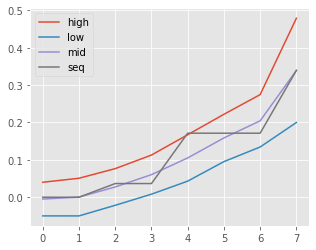

Buy at 41.715 (2021-11-23 09:30:57.191443)
Waiting until 2021-11-23 09:33:20 local time...


{'iter': 64, 'buy_at': 41.715, 'sell_at_10th': 41.933, 'gain_at_10th': 0.005225937912021968, 'sell_time_at_10th': Timestamp('2021-11-23 09:32:00'), 'sell_at_11th': 42.0, 'gain_at_11th': 0.006832074793239759, 'sell_time_at_11th': Timestamp('2021-11-23 09:33:00'), 'buy_time': Timestamp('2021-11-23 09:30:00'), 'buy_time_exact': Timestamp('2021-11-23 09:30:57.191443'), 'unblock_time': Timestamp('2021-11-23 09:33:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('SUSD', 1), ('SUSD', 3), ('SUSD', 5), ('SUSD', 15), ('USDP', 1)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('SUSD', 1), ('SUSD', 3), ('SUSD', 5), ('SUSD', 15), ('USDP', 1)]
New search started on freq=[1, 3, 5, 15]...

('DNT', 'USDT', 1, 0.021759666322519532)


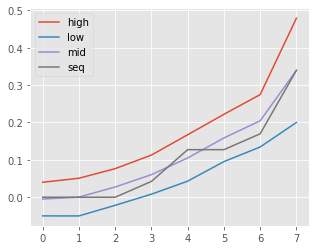

Buy at 0.1648 (2021-11-23 10:14:57.109832)
Waiting until 2021-11-23 10:17:20 local time...


{'iter': 65, 'buy_at': 0.1648, 'sell_at_10th': 0.1647, 'gain_at_10th': -0.0006067961165047875, 'sell_time_at_10th': Timestamp('2021-11-23 10:16:00'), 'sell_at_11th': 0.1647, 'gain_at_11th': -0.0006067961165047875, 'sell_time_at_11th': Timestamp('2021-11-23 10:17:00'), 'buy_time': Timestamp('2021-11-23 10:14:00'), 'buy_time_exact': Timestamp('2021-11-23 10:14:57.109832'), 'unblock_time': Timestamp('2021-11-23 10:17:20')}

New search started on freq=[1, 3, 5, 15]...

('ANKR', 'USDT', 1, 0.027379967052453606)


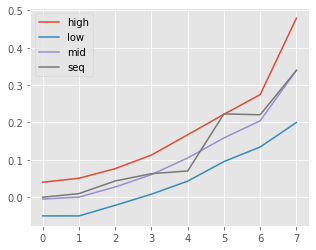

Buy at 0.1267 (2021-11-23 10:19:52.117787)
Waiting until 2021-11-23 10:22:20 local time...


{'iter': 66, 'buy_at': 0.1267, 'sell_at_10th': 0.12689, 'gain_at_10th': 0.001499605367008648, 'sell_time_at_10th': Timestamp('2021-11-23 10:21:00'), 'sell_at_11th': 0.1265, 'gain_at_11th': -0.0015785319652723419, 'sell_time_at_11th': Timestamp('2021-11-23 10:22:00'), 'buy_time': Timestamp('2021-11-23 10:19:00'), 'buy_time_exact': Timestamp('2021-11-23 10:19:52.117787'), 'unblock_time': Timestamp('2021-11-23 10:22:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('SUSD', 1), ('SUSD', 3), ('SUSD', 15)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('XTZDOWN', 1), ('NMR', 1), ('TRXDOWN', 1), ('SUSD', 1), ('SUSD', 3), ('SUSD', 15), ('XLMDOWN', 1), ('AUCTION', 1)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('SUSD', 1), ('SUSD', 3), ('SUSD', 5), ('SUSD', 15)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('YFIUP', 1), ('SUSD', 1), ('XLMDOWN', 1), ('MLN', 1), ('USDP', 1)]
New search started on freq=[1, 3, 5, 15]...

('BAND', 'USDT', 1, 0.0241038448548626

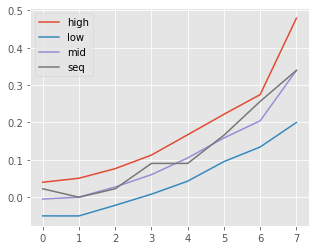

Buy at 7.267 (2021-11-23 11:31:14.313049)
Waiting until 2021-11-23 11:34:20 local time...


{'iter': 67, 'buy_at': 7.267, 'sell_at_10th': 7.259, 'gain_at_10th': -0.0011008669327095097, 'sell_time_at_10th': Timestamp('2021-11-23 11:33:00'), 'sell_at_11th': 7.259, 'gain_at_11th': -0.0011008669327095097, 'sell_time_at_11th': Timestamp('2021-11-23 11:34:00'), 'buy_time': Timestamp('2021-11-23 11:31:00'), 'buy_time_exact': Timestamp('2021-11-23 11:31:14.313049'), 'unblock_time': Timestamp('2021-11-23 11:34:20')}

New search started on freq=[1, 3, 5, 15]...

('XTZDOWN', 'USDT', 1, 0.02628018813743221)


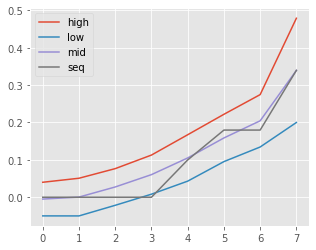

Buy at 3.214 (2021-11-23 11:40:46.939171)
Waiting until 2021-11-23 11:43:20 local time...


{'iter': 68, 'buy_at': 3.214, 'sell_at_10th': 3.217, 'gain_at_10th': 0.0009334163036714728, 'sell_time_at_10th': Timestamp('2021-11-23 11:42:00'), 'sell_at_11th': 3.213, 'gain_at_11th': -0.0003111387678904449, 'sell_time_at_11th': Timestamp('2021-11-23 11:43:00'), 'buy_time': Timestamp('2021-11-23 11:40:00'), 'buy_time_exact': Timestamp('2021-11-23 11:40:46.939171'), 'unblock_time': Timestamp('2021-11-23 11:43:20')}

New search started on freq=[1, 3, 5, 15]...

('DEXE', 'USDT', 5, 0.029483520956736512)


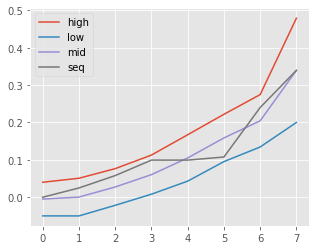

Buy at 14.03 (2021-11-23 11:56:42.887056)
Waiting until 2021-11-23 12:10:20 local time...


{'iter': 69, 'buy_at': 14.03, 'sell_at_10th': 13.95, 'gain_at_10th': -0.005702066999287247, 'sell_time_at_10th': Timestamp('2021-11-23 12:05:00'), 'sell_at_11th': 13.99, 'gain_at_11th': -0.0028510334996435602, 'sell_time_at_11th': Timestamp('2021-11-23 12:10:00'), 'buy_time': Timestamp('2021-11-23 11:55:00'), 'buy_time_exact': Timestamp('2021-11-23 11:56:42.887056'), 'unblock_time': Timestamp('2021-11-23 12:10:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('ONG', 1), ('YFIUP', 1), ('BCHDOWN', 1), ('SUSD', 1), ('SUSD', 3), ('SUSD', 5), ('RIF', 1)]
New search started on freq=[1, 3, 5, 15]...

('CTSI', 'USDT', 3, 0.01845155332115512)


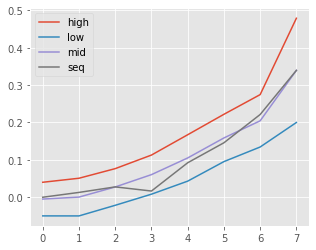

Buy at 0.9569 (2021-11-23 12:32:07.977660)
Waiting until 2021-11-23 12:39:20 local time...


{'iter': 70, 'buy_at': 0.9569, 'sell_at_10th': 0.9417, 'gain_at_10th': -0.01588462744278398, 'sell_time_at_10th': Timestamp('2021-11-23 12:36:00'), 'sell_at_11th': 0.9497, 'gain_at_11th': -0.007524297209739768, 'sell_time_at_11th': Timestamp('2021-11-23 12:39:00'), 'buy_time': Timestamp('2021-11-23 12:30:00'), 'buy_time_exact': Timestamp('2021-11-23 12:32:07.977660'), 'unblock_time': Timestamp('2021-11-23 12:39:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('REP', 1), ('YFIDOWN', 1), ('SUSD', 1), ('SUSD', 3), ('SUSD', 5), ('OG', 1), ('USDP', 1), ('USDP', 3)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('TRXDOWN', 1), ('SUSD', 1), ('SUSD', 3), ('SUSD', 5), ('USDP', 1), ('USDP', 3), ('USDP', 5)]
New search started on freq=[1, 3, 5, 15]...

('MTL', 'USDT', 5, 0.021654034112250437)


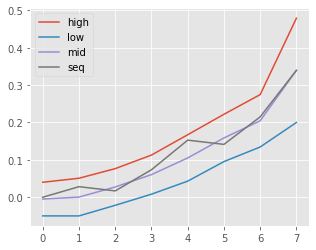

Buy at 3.01 (2021-11-23 13:17:49.702147)
Waiting until 2021-11-23 13:30:20 local time...


{'iter': 71, 'buy_at': 3.01, 'sell_at_10th': 3.016, 'gain_at_10th': 0.0019933554817276504, 'sell_time_at_10th': Timestamp('2021-11-23 13:25:00'), 'sell_at_11th': 3.006, 'gain_at_11th': -0.0013289036544850512, 'sell_time_at_11th': Timestamp('2021-11-23 13:30:00'), 'buy_time': Timestamp('2021-11-23 13:15:00'), 'buy_time_exact': Timestamp('2021-11-23 13:17:49.702147'), 'unblock_time': Timestamp('2021-11-23 13:30:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('YFIUP', 1), ('USDP', 1), ('USDP', 3)]
New search started on freq=[1, 3, 5, 15]...

('NBS', 'USDT', 15, 0.027678394411297238)


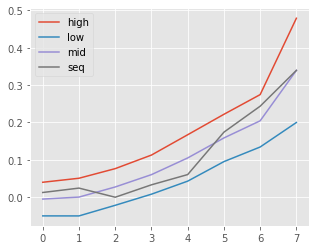

Buy at 0.02819 (2021-11-23 13:56:42.709895)
Waiting until 2021-11-23 14:30:20 local time...


{'iter': 72, 'buy_at': 0.02819, 'sell_at_10th': 0.02706, 'gain_at_10th': -0.0400851365732529, 'sell_time_at_10th': Timestamp('2021-11-23 14:15:00'), 'sell_at_11th': 0.02707, 'gain_at_11th': -0.03973040085136571, 'sell_time_at_11th': Timestamp('2021-11-23 14:30:00'), 'buy_time': Timestamp('2021-11-23 13:45:00'), 'buy_time_exact': Timestamp('2021-11-23 13:56:42.709895'), 'unblock_time': Timestamp('2021-11-23 14:30:20')}

New search started on freq=[1, 3, 5, 15]...

('BTC', 'USDT', 1, 0.02757896836860137)


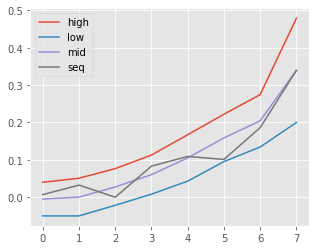

Buy at 57163.99 (2021-11-23 14:30:24.085038)
Waiting until 2021-11-23 14:33:20 local time...


{'iter': 73, 'buy_at': 57163.99, 'sell_at_10th': 57103.96, 'gain_at_10th': -0.0010501366332195993, 'sell_time_at_10th': Timestamp('2021-11-23 14:32:00'), 'sell_at_11th': 57027.42, 'gain_at_11th': -0.002389091454252926, 'sell_time_at_11th': Timestamp('2021-11-23 14:33:00'), 'buy_time': Timestamp('2021-11-23 14:30:00'), 'buy_time_exact': Timestamp('2021-11-23 14:30:24.085038'), 'unblock_time': Timestamp('2021-11-23 14:33:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('TRXDOWN', 1), ('YFIDOWN', 1), ('BCHUP', 1), ('SUSD', 1), ('SUSD', 3), ('USDP', 1), ('USDP', 3)]
New search started on freq=[1, 3, 5, 15]...

('BTC', 'USDT', 1, 0.023117091410054)


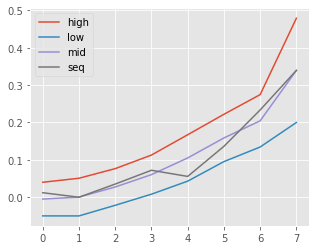

Buy at 57305.69 (2021-11-23 14:50:54.032276)
Waiting until 2021-11-23 14:53:20 local time...


{'iter': 74, 'buy_at': 57305.69, 'sell_at_10th': 57437.37, 'gain_at_10th': 0.0022978520981075403, 'sell_time_at_10th': Timestamp('2021-11-23 14:52:00'), 'sell_at_11th': 57423.61, 'gain_at_11th': 0.002057736326008783, 'sell_time_at_11th': Timestamp('2021-11-23 14:53:00'), 'buy_time': Timestamp('2021-11-23 14:50:00'), 'buy_time_exact': Timestamp('2021-11-23 14:50:54.032276'), 'unblock_time': Timestamp('2021-11-23 14:53:20')}

New search started on freq=[1, 3, 5, 15]...

('GTC', 'USDT', 5, 0.021797224035353162)


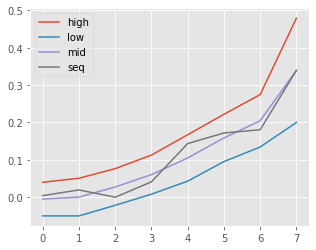

Buy at 8.521 (2021-11-23 15:07:55.363822)
Waiting until 2021-11-23 15:20:20 local time...


{'iter': 75, 'buy_at': 8.521, 'sell_at_10th': 8.485, 'gain_at_10th': -0.004224856237530966, 'sell_time_at_10th': Timestamp('2021-11-23 15:15:00'), 'sell_at_11th': 8.475, 'gain_at_11th': -0.005398427414622832, 'sell_time_at_11th': Timestamp('2021-11-23 15:20:00'), 'buy_time': Timestamp('2021-11-23 15:05:00'), 'buy_time_exact': Timestamp('2021-11-23 15:07:55.363822'), 'unblock_time': Timestamp('2021-11-23 15:20:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('SUSD', 1), ('XLMDOWN', 1), ('RIF', 1), ('USDP', 1)]
New search started on freq=[1, 3, 5, 15]...

Errors: [('NMR', 1), ('RIF', 1), ('GNO', 1), ('USDP', 1)]
New search started on freq=[1, 3, 5, 15]...

('NKN', 'USDT', 3, 0.020853059613041177)


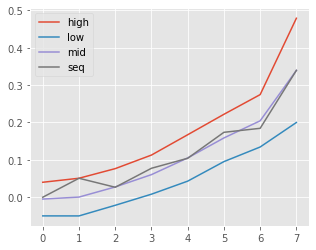

Buy at 0.5642 (2021-11-23 16:01:05.884261)
Waiting until 2021-11-23 16:09:20 local time...


{'iter': 76, 'buy_at': 0.5642, 'sell_at_10th': 0.5673, 'gain_at_10th': 0.005494505494505479, 'sell_time_at_10th': Timestamp('2021-11-23 16:06:00'), 'sell_at_11th': 0.5695, 'gain_at_11th': 0.009393831974477084, 'sell_time_at_11th': Timestamp('2021-11-23 16:09:00'), 'buy_time': Timestamp('2021-11-23 16:00:00'), 'buy_time_exact': Timestamp('2021-11-23 16:01:05.884261'), 'unblock_time': Timestamp('2021-11-23 16:09:20')}

New search started on freq=[1, 3, 5, 15]...

('COTI', 'USDT', 3, 0.02923524488303247)


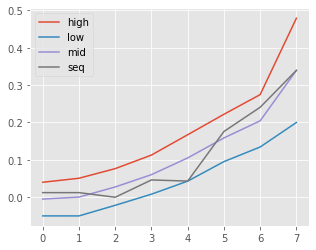

Buy at 0.4345 (2021-11-23 16:14:34.956405)
Waiting until 2021-11-23 16:21:20 local time...


{'iter': 77, 'buy_at': 0.4345, 'sell_at_10th': 0.4348, 'gain_at_10th': 0.0006904487917146662, 'sell_time_at_10th': Timestamp('2021-11-23 16:18:00'), 'sell_at_11th': 0.4348, 'gain_at_11th': 0.0006904487917146662, 'sell_time_at_11th': Timestamp('2021-11-23 16:21:00'), 'buy_time': Timestamp('2021-11-23 16:12:00'), 'buy_time_exact': Timestamp('2021-11-23 16:14:34.956405'), 'unblock_time': Timestamp('2021-11-23 16:21:20')}

New search started on freq=[1, 3, 5, 15]...

('DEGO', 'USDT', 5, 0.028101769937482656)


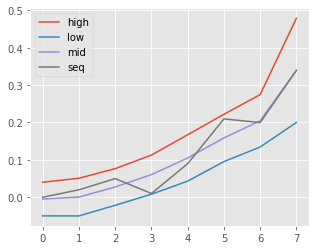

Buy at 11.43 (2021-11-23 16:34:11.133282)
Waiting until 2021-11-23 16:45:20 local time...


{'iter': 78, 'buy_at': 11.43, 'sell_at_10th': 11.35, 'gain_at_10th': -0.006999125109361336, 'sell_time_at_10th': Timestamp('2021-11-23 16:40:00'), 'sell_at_11th': 11.38, 'gain_at_11th': -0.004374453193350738, 'sell_time_at_11th': Timestamp('2021-11-23 16:45:00'), 'buy_time': Timestamp('2021-11-23 16:30:00'), 'buy_time_exact': Timestamp('2021-11-23 16:34:11.133282'), 'unblock_time': Timestamp('2021-11-23 16:45:20')}

New search started on freq=[1, 3, 5, 15]...

('DCR', 'USDT', 5, 0.02352368245038758)


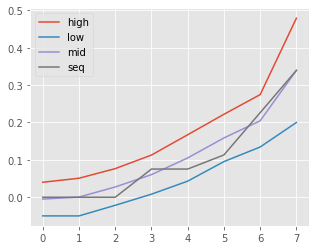

Buy at 109.0 (2021-11-23 16:52:49.322893)
Waiting until 2021-11-23 17:05:20 local time...


{'iter': 79, 'buy_at': 109.0, 'sell_at_10th': 109.2, 'gain_at_10th': 0.001834862385321127, 'sell_time_at_10th': Timestamp('2021-11-23 17:00:00'), 'sell_at_11th': 109.0, 'gain_at_11th': 0.0, 'sell_time_at_11th': Timestamp('2021-11-23 17:05:00'), 'buy_time': Timestamp('2021-11-23 16:50:00'), 'buy_time_exact': Timestamp('2021-11-23 16:52:49.322893'), 'unblock_time': Timestamp('2021-11-23 17:05:20')}

New search started on freq=[1, 3, 5, 15]...

('MITH', 'USDT', 5, 0.02850618567543996)


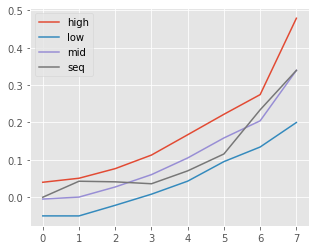

Buy at 0.09102 (2021-11-23 17:07:34.149114)
Waiting until 2021-11-23 17:20:20 local time...


{'iter': 80, 'buy_at': 0.09102, 'sell_at_10th': 0.09591, 'gain_at_10th': 0.05372445616348046, 'sell_time_at_10th': Timestamp('2021-11-23 17:15:00'), 'sell_at_11th': 0.09456, 'gain_at_11th': 0.038892551087673054, 'sell_time_at_11th': Timestamp('2021-11-23 17:20:00'), 'buy_time': Timestamp('2021-11-23 17:05:00'), 'buy_time_exact': Timestamp('2021-11-23 17:07:34.149114'), 'unblock_time': Timestamp('2021-11-23 17:20:20')}

New search started on freq=[1, 3, 5, 15]...

('FTM', 'USDT', 5, 0.014876525574181638)


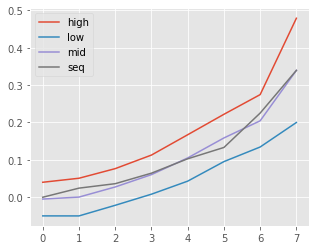

Buy at 2.4093 (2021-11-23 17:22:26.543662)
Waiting until 2021-11-23 17:35:20 local time...


{'iter': 81, 'buy_at': 2.4093, 'sell_at_10th': 2.3892, 'gain_at_10th': -0.008342672145436344, 'sell_time_at_10th': Timestamp('2021-11-23 17:30:00'), 'sell_at_11th': 2.3923, 'gain_at_11th': -0.007055991366786994, 'sell_time_at_11th': Timestamp('2021-11-23 17:35:00'), 'buy_time': Timestamp('2021-11-23 17:20:00'), 'buy_time_exact': Timestamp('2021-11-23 17:22:26.543662'), 'unblock_time': Timestamp('2021-11-23 17:35:20')}

New search started on freq=[1, 3, 5, 15]...

('CRV', 'USDT', 15, 0.027915395370350544)


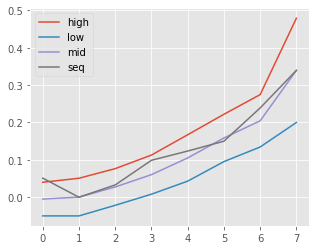

Buy at 4.85 (2021-11-23 17:42:32.945053)
Waiting until 2021-11-23 18:15:20 local time...


{'iter': 82, 'buy_at': 4.85, 'sell_at_10th': 4.851, 'gain_at_10th': 0.00020618556701037816, 'sell_time_at_10th': Timestamp('2021-11-23 18:00:00'), 'sell_at_11th': 4.845, 'gain_at_11th': -0.0010309278350515245, 'sell_time_at_11th': Timestamp('2021-11-23 18:15:00'), 'buy_time': Timestamp('2021-11-23 17:30:00'), 'buy_time_exact': Timestamp('2021-11-23 17:42:32.945053'), 'unblock_time': Timestamp('2021-11-23 18:15:20')}

New search started on freq=[1, 3, 5, 15]...

('SAND', 'USDT', 5, 0.019681169612997176)


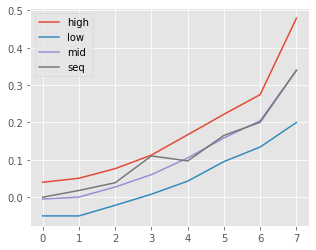

Buy at 5.5754 (2021-11-23 18:23:04.895549)
Waiting until 2021-11-23 18:35:20 local time...


{'iter': 83, 'buy_at': 5.5754, 'sell_at_10th': 5.5521, 'gain_at_10th': -0.004179072353553086, 'sell_time_at_10th': Timestamp('2021-11-23 18:30:00'), 'sell_at_11th': 5.5932, 'gain_at_11th': 0.003192596046920447, 'sell_time_at_11th': Timestamp('2021-11-23 18:35:00'), 'buy_time': Timestamp('2021-11-23 18:20:00'), 'buy_time_exact': Timestamp('2021-11-23 18:23:04.895549'), 'unblock_time': Timestamp('2021-11-23 18:35:20')}

New search started on freq=[1, 3, 5, 15]...

('MKR', 'USDT', 3, 0.025992415219758844)


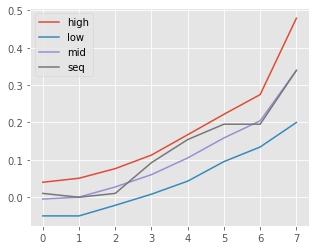

Buy at 3074.0 (2021-11-23 18:41:47.433860)
Waiting until 2021-11-23 18:48:20 local time...


{'iter': 84, 'buy_at': 3074.0, 'sell_at_10th': 3054.0, 'gain_at_10th': -0.006506180871828237, 'sell_time_at_10th': Timestamp('2021-11-23 18:45:00'), 'sell_at_11th': 3050.0, 'gain_at_11th': -0.007807417046193884, 'sell_time_at_11th': Timestamp('2021-11-23 18:48:00'), 'buy_time': Timestamp('2021-11-23 18:39:00'), 'buy_time_exact': Timestamp('2021-11-23 18:41:47.433860'), 'unblock_time': Timestamp('2021-11-23 18:48:20')}

New search started on freq=[1, 3, 5, 15]...

('TCT', 'USDT', 5, 0.028252473004082262)


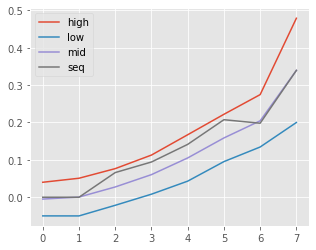

Buy at 0.03776 (2021-11-23 18:52:40.287724)
Waiting until 2021-11-23 19:05:20 local time...


{'iter': 85, 'buy_at': 0.03776, 'sell_at_10th': 0.0377, 'gain_at_10th': -0.0015889830508475766, 'sell_time_at_10th': Timestamp('2021-11-23 19:00:00'), 'sell_at_11th': 0.03771, 'gain_at_11th': -0.0013241525423729192, 'sell_time_at_11th': Timestamp('2021-11-23 19:05:00'), 'buy_time': Timestamp('2021-11-23 18:50:00'), 'buy_time_exact': Timestamp('2021-11-23 18:52:40.287724'), 'unblock_time': Timestamp('2021-11-23 19:05:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('YFIUP', 1), ('JUV', 1), ('ATM', 1), ('USDP', 1)]
New search started on freq=[1, 3, 5, 15]...

('KAVA', 'USDT', 3, 0.026109698723549485)


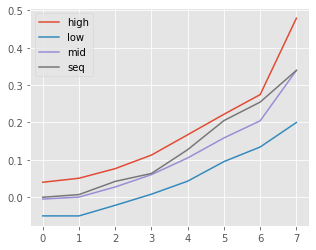

Buy at 5.424 (2021-11-23 19:25:49.409829)
Waiting until 2021-11-23 19:33:20 local time...


{'iter': 86, 'buy_at': 5.424, 'sell_at_10th': 5.421, 'gain_at_10th': -0.0005530973451327643, 'sell_time_at_10th': Timestamp('2021-11-23 19:30:00'), 'sell_at_11th': 5.414, 'gain_at_11th': -0.0018436578171092688, 'sell_time_at_11th': Timestamp('2021-11-23 19:33:00'), 'buy_time': Timestamp('2021-11-23 19:24:00'), 'buy_time_exact': Timestamp('2021-11-23 19:25:49.409829'), 'unblock_time': Timestamp('2021-11-23 19:33:20')}

New search started on freq=[1, 3, 5, 15]...

('KNC', 'USDT', 1, 0.028170553560130304)


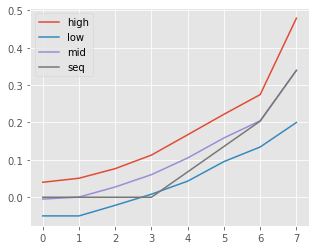

Buy at 1.759 (2021-11-23 19:39:03.350941)
Waiting until 2021-11-23 19:41:20 local time...


{'iter': 87, 'buy_at': 1.759, 'sell_at_10th': 1.759, 'gain_at_10th': 0.0, 'sell_time_at_10th': Timestamp('2021-11-23 19:40:00'), 'sell_at_11th': 1.758, 'gain_at_11th': -0.0005685048322910119, 'sell_time_at_11th': Timestamp('2021-11-23 19:41:00'), 'buy_time': Timestamp('2021-11-23 19:38:00'), 'buy_time_exact': Timestamp('2021-11-23 19:39:03.350941'), 'unblock_time': Timestamp('2021-11-23 19:41:20')}

New search started on freq=[1, 3, 5, 15]...

('BNB', 'USDT', 15, 0.02750766025146028)


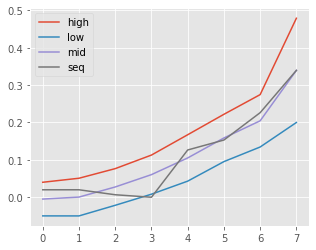

Buy at 602.2 (2021-11-23 19:41:31.084775)
Waiting until 2021-11-23 20:15:20 local time...


{'iter': 88, 'buy_at': 602.2, 'sell_at_10th': 604.0, 'gain_at_10th': 0.002989040185984647, 'sell_time_at_10th': Timestamp('2021-11-23 20:00:00'), 'sell_at_11th': 604.2, 'gain_at_11th': 0.0033211557622052474, 'sell_time_at_11th': Timestamp('2021-11-23 20:15:00'), 'buy_time': Timestamp('2021-11-23 19:30:00'), 'buy_time_exact': Timestamp('2021-11-23 19:41:31.084775'), 'unblock_time': Timestamp('2021-11-23 20:15:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('YFIDOWN', 1), ('BCHDOWN', 1), ('SUSD', 1), ('SUSD', 3), ('SUSD', 5), ('USDP', 1)]
New search started on freq=[1, 3, 5, 15]...

('STPT', 'USDT', 3, 0.02622613290119582)


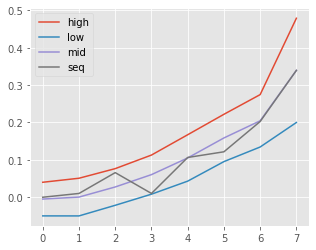

Buy at 0.14145 (2021-11-23 20:39:00.921813)
Waiting until 2021-11-23 20:45:20 local time...


{'iter': 89, 'buy_at': 0.14145, 'sell_at_10th': 0.14135, 'gain_at_10th': -0.0007069635913749664, 'sell_time_at_10th': Timestamp('2021-11-23 20:42:00'), 'sell_at_11th': 0.14124, 'gain_at_11th': -0.0014846235418875078, 'sell_time_at_11th': Timestamp('2021-11-23 20:45:00'), 'buy_time': Timestamp('2021-11-23 20:36:00'), 'buy_time_exact': Timestamp('2021-11-23 20:39:00.921813'), 'unblock_time': Timestamp('2021-11-23 20:45:20')}

New search started on freq=[1, 3, 5, 15]...

('BTCST', 'USDT', 15, 0.027564621446470827)


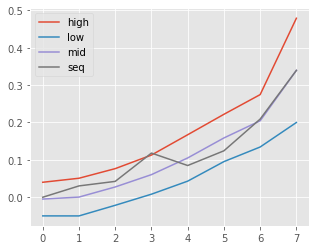

Buy at 33.61 (2021-11-23 20:57:22.924442)
Waiting until 2021-11-23 21:30:20 local time...


{'iter': 90, 'buy_at': 33.61, 'sell_at_10th': 33.28, 'gain_at_10th': -0.009818506396905633, 'sell_time_at_10th': Timestamp('2021-11-23 21:15:00'), 'sell_at_11th': 33.21, 'gain_at_11th': -0.01190121987503715, 'sell_time_at_11th': Timestamp('2021-11-23 21:30:00'), 'buy_time': Timestamp('2021-11-23 20:45:00'), 'buy_time_exact': Timestamp('2021-11-23 20:57:22.924442'), 'unblock_time': Timestamp('2021-11-23 21:30:20')}

New search started on freq=[1, 3, 5, 15]...

('BNBDOWN', 'USDT', 15, 0.024464287176466502)


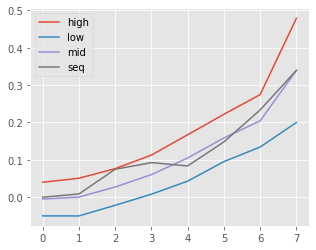

Buy at 0.0863 (2021-11-23 21:37:04.576770)
Waiting until 2021-11-23 22:15:20 local time...


{'iter': 91, 'buy_at': 0.0863, 'sell_at_10th': 0.0865, 'gain_at_10th': 0.0023174971031285265, 'sell_time_at_10th': Timestamp('2021-11-23 22:00:00'), 'sell_at_11th': 0.08637, 'gain_at_11th': 0.0008111239860950245, 'sell_time_at_11th': Timestamp('2021-11-23 22:15:00'), 'buy_time': Timestamp('2021-11-23 21:30:00'), 'buy_time_exact': Timestamp('2021-11-23 21:37:04.576770'), 'unblock_time': Timestamp('2021-11-23 22:15:20')}

New search started on freq=[1, 3, 5, 15]...

('FOR', 'USDT', 3, 0.027377339632455193)


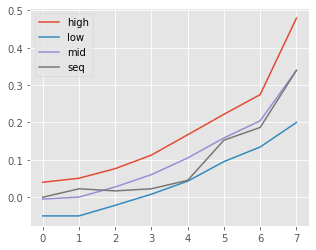

Buy at 0.08106 (2021-11-23 22:30:08.802621)
Waiting until 2021-11-23 22:36:20 local time...


{'iter': 92, 'buy_at': 0.08106, 'sell_at_10th': 0.08106, 'gain_at_10th': 0.0, 'sell_time_at_10th': Timestamp('2021-11-23 22:33:00'), 'sell_at_11th': 0.08146, 'gain_at_11th': 0.004934616333580206, 'sell_time_at_11th': Timestamp('2021-11-23 22:36:00'), 'buy_time': Timestamp('2021-11-23 22:27:00'), 'buy_time_exact': Timestamp('2021-11-23 22:30:08.802621'), 'unblock_time': Timestamp('2021-11-23 22:36:20')}

New search started on freq=[1, 3, 5, 15]...

('XRP', 'USDT', 1, 0.02915415016343805)


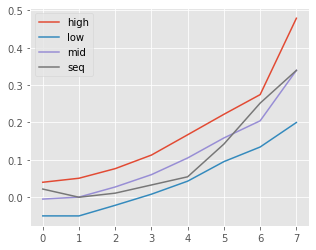

Buy at 1.0624 (2021-11-23 22:36:46.770570)
Waiting until 2021-11-23 22:39:20 local time...


{'iter': 93, 'buy_at': 1.0624, 'sell_at_10th': 1.0635, 'gain_at_10th': 0.0010353915662649463, 'sell_time_at_10th': Timestamp('2021-11-23 22:38:00'), 'sell_at_11th': 1.0633, 'gain_at_11th': 0.0008471385542167741, 'sell_time_at_11th': Timestamp('2021-11-23 22:39:00'), 'buy_time': Timestamp('2021-11-23 22:36:00'), 'buy_time_exact': Timestamp('2021-11-23 22:36:46.770570'), 'unblock_time': Timestamp('2021-11-23 22:39:20')}

New search started on freq=[1, 3, 5, 15]...

('SUSHIDOWN', 'USDT', 3, 0.02790537814719211)


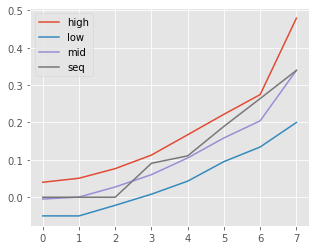

Buy at 39.805 (2021-11-23 22:51:16.182683)
Waiting until 2021-11-23 23:00:20 local time...


{'iter': 94, 'buy_at': 39.805, 'sell_at_10th': 39.666, 'gain_at_10th': -0.003492023615123801, 'sell_time_at_10th': Timestamp('2021-11-23 22:57:00'), 'sell_at_11th': 39.41, 'gain_at_11th': -0.009923376460243766, 'sell_time_at_11th': Timestamp('2021-11-23 23:00:00'), 'buy_time': Timestamp('2021-11-23 22:51:00'), 'buy_time_exact': Timestamp('2021-11-23 22:51:16.182683'), 'unblock_time': Timestamp('2021-11-23 23:00:20')}

New search started on freq=[1, 3, 5, 15]...

('SYS', 'USDT', 1, 0.022851565790006804)


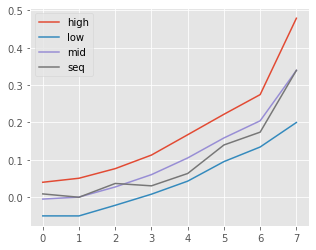

Buy at 0.6017 (2021-11-23 23:16:54.059552)
Waiting until 2021-11-23 23:19:20 local time...


{'iter': 95, 'buy_at': 0.6017, 'sell_at_10th': 0.6064, 'gain_at_10th': 0.007811201595479537, 'sell_time_at_10th': Timestamp('2021-11-23 23:18:00'), 'sell_at_11th': 0.6005, 'gain_at_11th': -0.0019943493435266393, 'sell_time_at_11th': Timestamp('2021-11-23 23:19:00'), 'buy_time': Timestamp('2021-11-23 23:16:00'), 'buy_time_exact': Timestamp('2021-11-23 23:16:54.059552'), 'unblock_time': Timestamp('2021-11-23 23:19:20')}

New search started on freq=[1, 3, 5, 15]...

Errors: [('FILDOWN', 1), ('SUSD', 1), ('MDX', 1), ('MLN', 1), ('USDP', 1), ('USDP', 3), ('USDP', 5)]
New search started on freq=[1, 3, 5, 15]...

('XLM', 'USDT', 15, 0.024749892949656946)


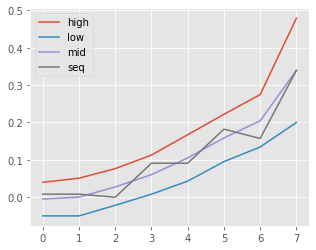

Buy at 0.3424 (2021-11-23 23:37:19.164030)
Waiting until 2021-11-24 00:15:20 local time...


{'iter': 96, 'buy_at': 0.3424, 'sell_at_10th': 0.3412, 'gain_at_10th': -0.0035046728971962, 'sell_time_at_10th': Timestamp('2021-11-24 00:00:00'), 'sell_at_11th': 0.3395, 'gain_at_11th': -0.008469626168224177, 'sell_time_at_11th': Timestamp('2021-11-24 00:15:00'), 'buy_time': Timestamp('2021-11-23 23:30:00'), 'buy_time_exact': Timestamp('2021-11-23 23:37:19.164030'), 'unblock_time': Timestamp('2021-11-24 00:15:20')}

New search started on freq=[1, 3, 5, 15]...

('YFII', 'USDT', 3, 0.023043688166048404)


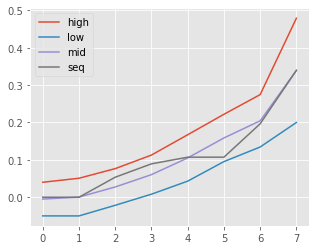

Buy at 3864.0 (2021-11-24 00:23:55.131463)
Waiting until 2021-11-24 00:30:20 local time...


{'iter': 97, 'buy_at': 3864.0, 'sell_at_10th': 3864.0, 'gain_at_10th': 0.0, 'sell_time_at_10th': Timestamp('2021-11-24 00:27:00'), 'sell_at_11th': 3864.0, 'gain_at_11th': 0.0, 'sell_time_at_11th': Timestamp('2021-11-24 00:30:00'), 'buy_time': Timestamp('2021-11-24 00:21:00'), 'buy_time_exact': Timestamp('2021-11-24 00:23:55.131463'), 'unblock_time': Timestamp('2021-11-24 00:30:20')}

New search started on freq=[1, 3, 5, 15]...

('SOL', 'USDT', 1, 0.026945047833100567)


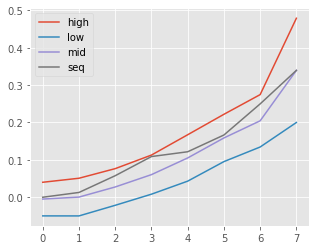

Buy at 221.67 (2021-11-24 00:35:41.106377)
Waiting until 2021-11-24 00:38:20 local time...


{'iter': 98, 'buy_at': 221.67, 'sell_at_10th': 221.34, 'gain_at_10th': -0.0014886994180537921, 'sell_time_at_10th': Timestamp('2021-11-24 00:37:00'), 'sell_at_11th': 221.55, 'gain_at_11th': -0.0005413452429285701, 'sell_time_at_11th': Timestamp('2021-11-24 00:38:00'), 'buy_time': Timestamp('2021-11-24 00:35:00'), 'buy_time_exact': Timestamp('2021-11-24 00:35:41.106377'), 'unblock_time': Timestamp('2021-11-24 00:38:20')}

New search started on freq=[1, 3, 5, 15]...

('CTSI', 'USDT', 15, 0.029380106208300977)


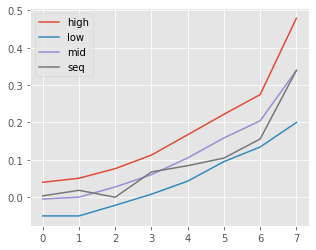

Buy at 1.0126 (2021-11-24 00:43:45.161052)
Waiting until 2021-11-24 01:15:20 local time...


{'iter': 99, 'buy_at': 1.0126, 'sell_at_10th': 0.9932, 'gain_at_10th': -0.0191586016195931, 'sell_time_at_10th': Timestamp('2021-11-24 01:00:00'), 'sell_at_11th': 0.9859, 'gain_at_11th': -0.026367766146553374, 'sell_time_at_11th': Timestamp('2021-11-24 01:15:00'), 'buy_time': Timestamp('2021-11-24 00:30:00'), 'buy_time_exact': Timestamp('2021-11-24 00:43:45.161052'), 'unblock_time': Timestamp('2021-11-24 01:15:20')}



In [28]:
import pause
import pandas as pd

delete_cache()

base = 'USDT'
actions = []
datapoints = 8

all_coins = get_binance_coins(base=base)
frequencies = [1, 3, 5, 15]

for i in range(100):

    search_res = None
    while search_res is None:
        print(f"New search started on freq={frequencies}...\n")
        search_res = run_search(base, all_coins, freqs=frequencies, backtest=False, datapoints=datapoints, thr=0.03)

    buy_at = search_res['seq'][-1]
    buy_time = search_res['seq'].index[-1]
    buy_time_exact = pd.Timestamp.now()
    print(f"Buy at {buy_at} ({buy_time_exact})")

    # sleep until next iteration
    unblock_time = buy_time + timedelta(minutes=(11-datapoints) * search_res['freq'], seconds=20)
    print(f"Waiting until {unblock_time.strftime('%Y-%m-%d %H:%M:%S')} local time...")
    pause.until(unblock_time)
    
    # to check both at 10th and 11th datapoint
    df_sell_time = buy_time - timedelta(minutes=datapoints * search_res['freq'])
    df_sell = download_history_fast(f"{search_res['coin']}{search_res['base']}", df_sell_time.strftime('%Y%m%d%H%M%S'), 
                                        freq=search_res['freq'], days=1)
    
    sell_at_10th = df_sell['open'].iloc[10]
    sell_time_at_10th = df_sell.index[10]
    gain_at_10th = (sell_at_10th - buy_at) / buy_at

    sell_at_11th = df_sell['open'].iloc[11]
    sell_time_at_11th = df_sell.index[11]
    gain_at_11th = (sell_at_11th - buy_at) / buy_at

    action = {
        'params': {
            'iter': i, 'buy_at': buy_at, 
            'sell_at_10th': sell_at_10th, 'gain_at_10th': gain_at_10th, 'sell_time_at_10th': sell_time_at_10th,
            'sell_at_11th': sell_at_11th, 'gain_at_11th': gain_at_11th, 'sell_time_at_11th': sell_time_at_11th,
            'buy_time': buy_time, 'buy_time_exact': buy_time_exact, 'unblock_time': unblock_time,
        },
        'data': {
            'search_res': search_res, 'df_sell': df_sell,
        }
    }
    actions.append(action)
    print(action['params'])
    print()

In [29]:
with open('hc-actions.pkl', 'wb') as f_out:
    pickle.dump(actions, f_out)

In [50]:
stakes = [1]
for action in actions:
    if action['data']['search_res']['freq'] != 15:
        stakes.append(stakes[-1] * (1 + action['params']['gain_at_10th']))

df_actions = pd.DataFrame([{'stake': s} for s in stakes])

df_actions['stake']

0     1.000000
1     0.998730
2     1.007990
3     1.006576
4     1.027112
        ...   
77    0.988588
78    0.985136
79    0.992831
80    0.992831
81    0.991353
Name: stake, Length: 82, dtype: float64

### Todo

* Try with TP + SL

## Further analysis

In [38]:
search['OM'][240]

{'seq': 2021-11-19 20:00:00    0.2155
 2021-11-20 00:00:00    0.2162
 2021-11-20 04:00:00    0.2194
 2021-11-20 08:00:00    0.2210
 2021-11-20 12:00:00    0.2161
 2021-11-20 16:00:00    0.2269
 2021-11-20 20:00:00    0.2314
 2021-11-21 00:00:00    0.2424
 Name: close, dtype: float64,
 'score': 0.036041505450090064}

In [37]:
import pandas as pd

def not_leverage(coin):
    return not coin.endswith('UP') and not coin.endswith('DOWN')

search_data = []
for coin, x in search.items():
    for freq, y in x.items():
        search_data.append({'coin': coin, 'freq': freq, 'score': y['score']})
df_search = pd.DataFrame(search_data)

df_search[df_search['coin'].map(not_leverage)].sort_values(by='score')[:20]

,coin,freq,score
237,ZEC,5,0.024512
73,TUSD,120,0.033676
425,PERL,120,0.035913
1877,OM,240,0.036042
736,STPT,240,0.036096
1767,CELO,60,0.036504
780,HIVE,15,0.038502
1878,OM,120,0.038787
1880,OM,30,0.039207
424,PERL,240,0.040114


In [31]:
for coin in df_search.sort_values(by='score')[:20]['coin']:
    print((coin, coin in top_50_coins))

('TRXUP', False)
('ZEC', True)
('TUSD', False)
('PERL', True)
('OM', False)
('STPT', True)
('CELO', False)
('BCHDOWN', False)
('HIVE', False)
('OM', False)
('LTCDOWN', False)
('OM', False)
('PERL', True)
('TUSD', False)
('OM', False)
('ICP', False)
('DREP', True)
('ROSE', False)
('DAR', True)
('SUSHIDOWN', False)
